In [5]:
import os
import glob
import re
import numpy as np
import rasterio
import geopandas as gpd
from rasterio.mask import geometry_mask
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample

In [10]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

all_image_paths = image_paths + unlabeled_image_paths

def pair_files(all_image_paths, shapefile_paths, walrus_paths):
    file_pairs = {}
    for image_path in all_image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        # Pair with general shapefiles
        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        general_shapefile = matching_shapefiles[0] if matching_shapefiles else None

        # Pair with walrus shapefiles
        matching_walrus = [walrus for walrus in walrus_paths if island in walrus and date in walrus]
        walrus_shapefile = matching_walrus[0] if matching_walrus else None

        if general_shapefile or walrus_shapefile:
            file_pairs[image_path] = (general_shapefile, walrus_shapefile)

    return file_pairs

file_pairs = pair_files(all_image_paths, shapefile_paths, new_walrus_paths)

def extract_features_labels(image_path, general_shapefile, walrus_shapefile):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    features = []
    labels = []
    img_name = []

    # Process general shapefile
    if general_shapefile:
        gdf = gpd.read_file(general_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    # Process walrus shapefile
    if walrus_shapefile:
        gdf = gpd.read_file(walrus_shapefile)
        for _, row in gdf.iterrows():
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            feature_pixels = image[:, mask]
            for pixel in feature_pixels.T:
                features.append(pixel)
                labels.append(row['label'])
                img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, (general_shapefile, walrus_shapefile) in file_pairs.items():
        img_features, img_labels, img_name = extract_features_labels(image_path, general_shapefile, walrus_shapefile)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

features, labels, image_name = get_dataset(file_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_name
})

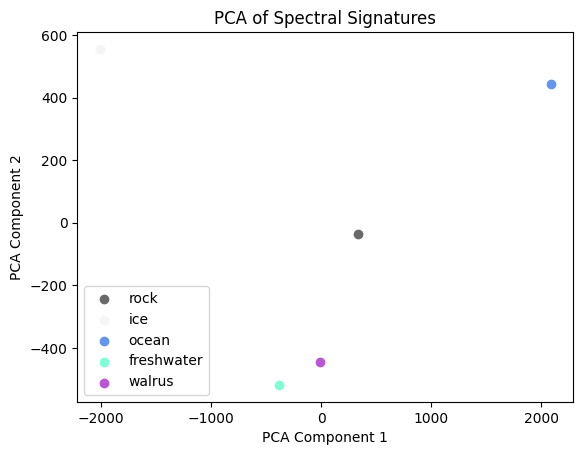

In [11]:
# Function to extract spectral signatures for a given class
def extract_spectral_signatures(image_path, shapefile_path, target_classes):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    class_pixels = {cls: [] for cls in target_classes}

    for _, row in gdf.iterrows():
        if row['label'] in target_classes:
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            class_pixels[row['label']].append(image[:, mask])

    for cls in target_classes:
        if class_pixels[cls]:
            class_pixels[cls] = np.concatenate(class_pixels[cls], axis=1)
            class_spectral_signature = np.mean(class_pixels[cls], axis=1)
            class_pixels[cls] = class_spectral_signature
        else:
            class_pixels[cls] = None

    return class_pixels

# Define target classes
target_classes = ['walrus_pure', 'walrus_mixed', 'rock', 'ice', 'ocean', 'freshwater']

# Extract and store spectral signatures for all classes
all_spectral_signatures = {cls: [] for cls in target_classes}

for image_path, (general_shapefile, walrus_shapefile) in file_pairs.items():
    if general_shapefile:
        signatures = extract_spectral_signatures(image_path, general_shapefile, target_classes)
        for cls, signature in signatures.items():
            if signature is not None:
                all_spectral_signatures[cls].append(signature)
    if walrus_shapefile:
        signatures = extract_spectral_signatures(image_path, walrus_shapefile, target_classes)
        for cls, signature in signatures.items():
            if signature is not None:
                all_spectral_signatures[cls].append(signature)

# Calculate mean spectral signature for each class
mean_spectral_signatures = {}
for cls, signatures in all_spectral_signatures.items():
    if signatures:
        mean_spectral_signatures[cls] = np.mean(signatures, axis=0)

# Combine walrus_pure and walrus_mixed into one class
walrus_signatures = []
if 'walrus_pure' in mean_spectral_signatures:
    walrus_signatures.append(mean_spectral_signatures.pop('walrus_pure'))
if 'walrus_mixed' in mean_spectral_signatures:
    walrus_signatures.append(mean_spectral_signatures.pop('walrus_mixed'))

if walrus_signatures:
    mean_spectral_signatures['walrus'] = np.mean(walrus_signatures, axis=0)

# Define the color mapping for each class
label_colors = {
    'ice': 'whitesmoke',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine',
    'walrus': 'mediumorchid'  # Combined walrus class color
}

# Apply PCA for dimensionality reduction and visualization
all_signatures_combined = np.vstack([mean_spectral_signatures[cls] for cls in mean_spectral_signatures])
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(all_signatures_combined)

# Plot the PCA transformed spectral signatures
plt.figure()
for i, cls in enumerate(mean_spectral_signatures):
    plt.scatter(pca_transformed[i, 0], pca_transformed[i, 1], label=cls, color=label_colors[cls])
plt.legend()
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Spectral Signatures')
plt.show()

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
import seaborn as sns

Euclidean distances between classes:
[[   0.         2421.5804782  1819.01973033  882.16538181  537.95690897]
 [2421.5804782     0.         4099.8930809  1951.80635129 2239.40066198]
 [1819.01973033 4099.8930809     0.         2652.23577835 2278.88796577]
 [ 882.16538181 1951.80635129 2652.23577835    0.          407.33029792]
 [ 537.95690897 2239.40066198 2278.88796577  407.33029792    0.        ]]


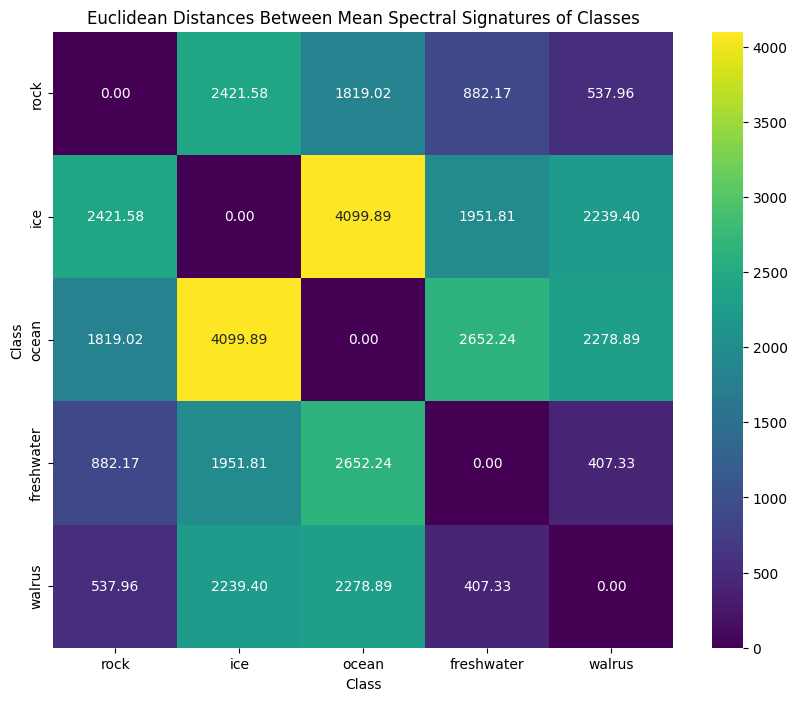

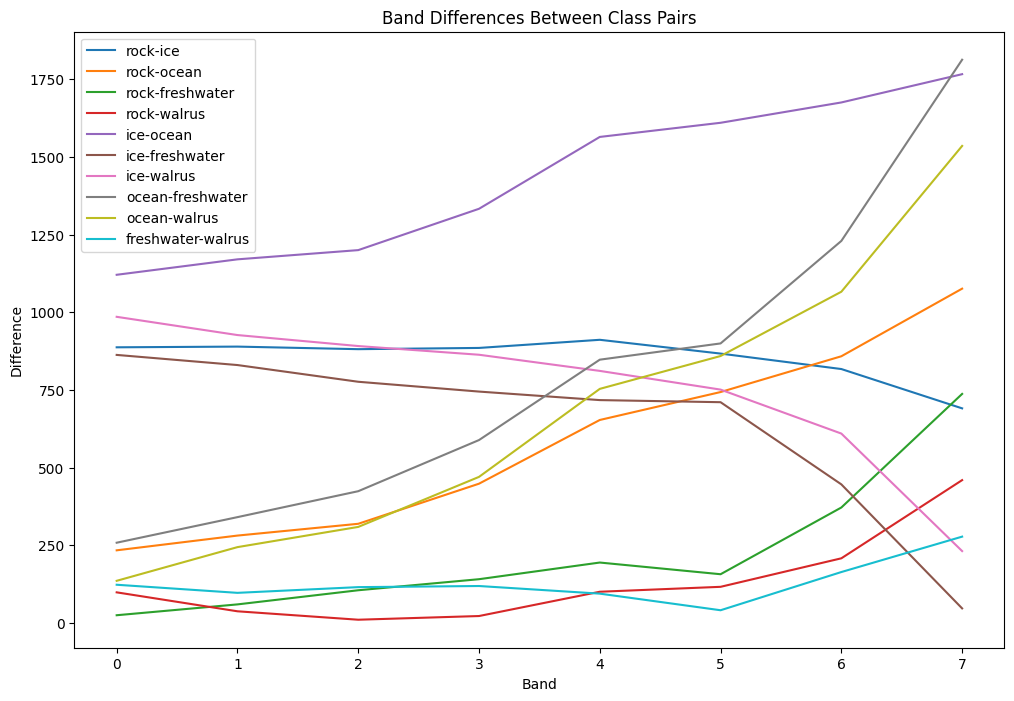

In [13]:
# Function to calculate Euclidean distances between the mean spectral signatures of the classes
def calculate_euclidean_distances(mean_spectral_signatures):
    classes = list(mean_spectral_signatures.keys())
    distances = np.zeros((len(classes), len(classes)))
    for i, cls1 in enumerate(classes):
        for j, cls2 in enumerate(classes):
            distances[i, j] = euclidean(mean_spectral_signatures[cls1], mean_spectral_signatures[cls2])
    return distances, classes

distances, classes = calculate_euclidean_distances(mean_spectral_signatures)

# Function to calculate differences across the classes band by band
def calculate_band_differences(mean_spectral_signatures):
    classes = list(mean_spectral_signatures.keys())
    band_differences = {}
    for i, cls1 in enumerate(classes):
        for j, cls2 in enumerate(classes):
            if i < j:
                difference = np.abs(mean_spectral_signatures[cls1] - mean_spectral_signatures[cls2])
                band_differences[f"{cls1}-{cls2}"] = difference
    return band_differences

band_differences = calculate_band_differences(mean_spectral_signatures)

# Print Euclidean distances
print("Euclidean distances between classes:")
print(distances)

# Plot the Euclidean distance matrix
plt.figure(figsize=(10, 8))
sns.heatmap(distances, xticklabels=classes, yticklabels=classes, annot=True, fmt=".2f", cmap="viridis")
plt.title("Euclidean Distances Between Mean Spectral Signatures of Classes")
plt.xlabel("Class")
plt.ylabel("Class")
plt.show()

# Plot the band differences
fig, ax = plt.subplots(figsize=(12, 8))
for pair, differences in band_differences.items():
    ax.plot(differences, label=pair)
ax.set_xlabel("Band")
ax.set_ylabel("Difference")
ax.set_title("Band Differences Between Class Pairs")
ax.legend()
plt.show()

Euclidean distances between classes:
[[   0.         2421.5804782  1819.01973033  882.16538181  537.95690897]
 [2421.5804782     0.         4099.8930809  1951.80635129 2239.40066198]
 [1819.01973033 4099.8930809     0.         2652.23577835 2278.88796577]
 [ 882.16538181 1951.80635129 2652.23577835    0.          407.33029792]
 [ 537.95690897 2239.40066198 2278.88796577  407.33029792    0.        ]]


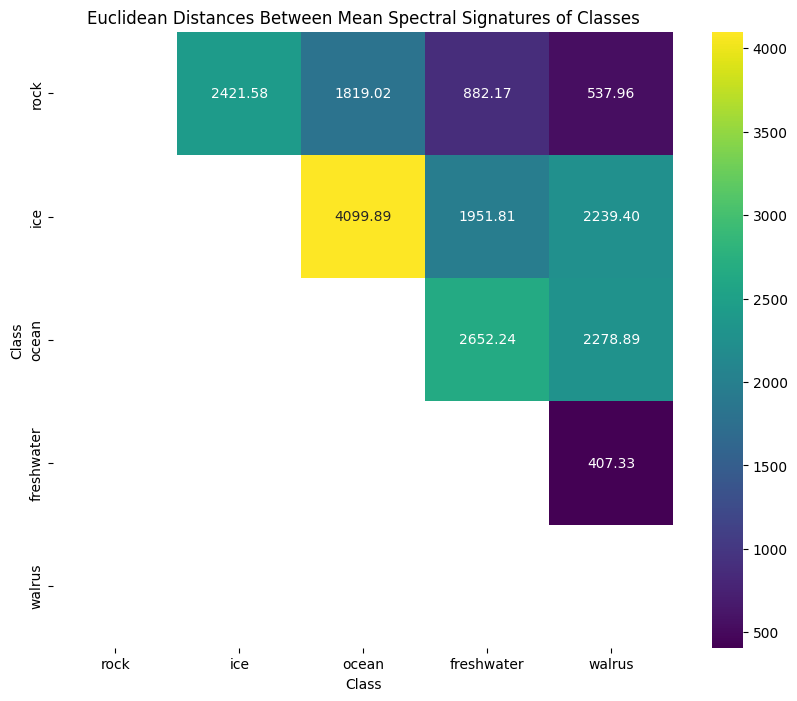

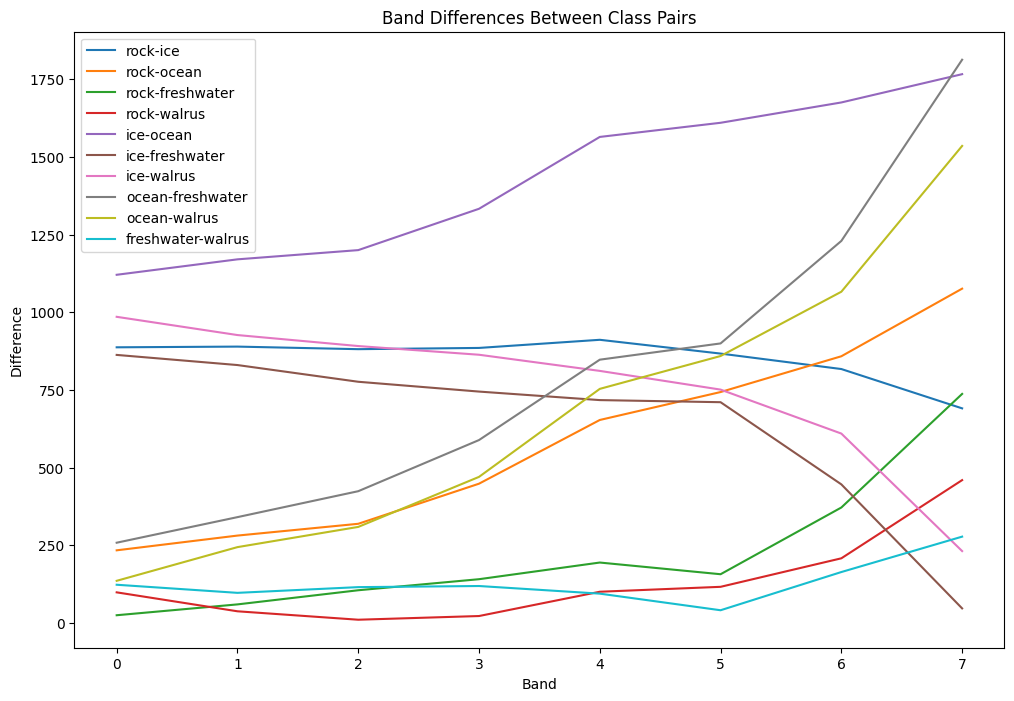

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
import seaborn as sns

# Function to calculate Euclidean distances between the mean spectral signatures of the classes
def calculate_euclidean_distances(mean_spectral_signatures):
    classes = list(mean_spectral_signatures.keys())
    distances = np.zeros((len(classes), len(classes)))
    for i, cls1 in enumerate(classes):
        for j, cls2 in enumerate(classes):
            distances[i, j] = euclidean(mean_spectral_signatures[cls1], mean_spectral_signatures[cls2])
    return distances, classes

distances, classes = calculate_euclidean_distances(mean_spectral_signatures)

# Function to calculate differences across the classes band by band
def calculate_band_differences(mean_spectral_signatures):
    classes = list(mean_spectral_signatures.keys())
    band_differences = {}
    for i, cls1 in enumerate(classes):
        for j, cls2 in enumerate(classes):
            if i < j:
                difference = np.abs(mean_spectral_signatures[cls1] - mean_spectral_signatures[cls2])
                band_differences[f"{cls1}-{cls2}"] = difference
    return band_differences

band_differences = calculate_band_differences(mean_spectral_signatures)

# Print Euclidean distances
print("Euclidean distances between classes:")
print(distances)

# Mask the lower triangle of the distance matrix
mask = np.tril(np.ones_like(distances, dtype=bool))

# Plot the Euclidean distance matrix (upper triangle only)
plt.figure(figsize=(10, 8))
sns.heatmap(distances, xticklabels=classes, yticklabels=classes, annot=True, fmt=".2f", cmap="viridis", mask=mask)
plt.title("Euclidean Distances Between Mean Spectral Signatures of Classes")
plt.xlabel("Class")
plt.ylabel("Class")
plt.show()

# Plot the band differences
fig, ax = plt.subplots(figsize=(12, 8))
for pair, differences in band_differences.items():
    ax.plot(differences, label=pair)
ax.set_xlabel("Band")
ax.set_ylabel("Difference")
ax.set_title("Band Differences Between Class Pairs")
ax.legend()
plt.show()


In [11]:
# Calculate Euclidean distances between the mean spectral signatures of the classes
def calculate_euclidean_distances(mean_spectral_signatures):
    classes = list(mean_spectral_signatures.keys())
    distances = np.zeros((len(classes), len(classes)))
    for i, cls1 in enumerate(classes):
        for j, cls2 in enumerate(classes):
            distances[i, j] = euclidean(mean_spectral_signatures[cls1], mean_spectral_signatures[cls2])
    return distances, classes

distances, classes = calculate_euclidean_distances(mean_spectral_signatures)

# Calculate differences across the classes band by band
def calculate_band_differences(mean_spectral_signatures):
    classes = list(mean_spectral_signatures.keys())
    band_differences = {cls: [] for cls in classes}
    for i, cls1 in enumerate(classes):
        for j, cls2 in enumerate(classes):
            if i < j:
                difference = np.abs(mean_spectral_signatures[cls1] - mean_spectral_signatures[cls2])
                band_differences[f"{cls1}-{cls2}"] = difference
    return band_differences

band_differences = calculate_band_differences(mean_spectral_signatures)

# Print Euclidean distances
print("Euclidean distances between classes:")
print(distances)

Euclidean distances between classes:
[[   0.         3006.13914561 1691.98006927  962.41724386  487.86504863]
 [3006.13914561    0.         4498.06721172 2415.7359524  2784.86679751]
 [1691.98006927 4498.06721172    0.         2630.91992663 2144.22913182]
 [ 962.41724386 2415.7359524  2630.91992663    0.          521.90214028]
 [ 487.86504863 2784.86679751 2144.22913182  521.90214028    0.        ]]


In [12]:
# Print band differences
print("Band differences between classes:")
for key, value in band_differences.items():
    print(f"{key}: {value}")

Band differences between classes:
rock: []
ice: []
ocean: []
freshwater: []
walrus: []
rock-ice: [1151.53506645 1136.3670614  1110.76205798 1094.26274774 1122.18300331
 1054.31858361  981.99201404  808.15559173]
rock-ocean: [ 174.29692318  232.41565312  247.17109383  391.09909577  561.53743991
  677.30854625  806.77744139 1067.42074462]
rock-freshwater: [ 61.66628179  98.72125272 148.27274417 186.98314804 248.35095608
 198.23385835 413.38553325 764.12588742]
rock-walrus: [ 80.93267455   4.55419254  15.79349617  35.42973047 108.67411073
 142.8746642  202.58887571 395.81723345]
ice-ocean: [1325.83198963 1368.78271451 1357.93315181 1485.36184351 1683.72044322
 1731.62712986 1788.76945542 1875.57633635]
ice-freshwater: [1089.86878466 1037.64580868  962.4893138   907.2795997   873.83204723
  856.08472526  568.60648079   44.02970431]
ice-walrus: [1232.46774101 1131.81286885 1094.96856181 1058.83301727 1013.50889258
  911.44391941  779.40313833  412.33835828]
ocean-freshwater: [ 235.96320497 

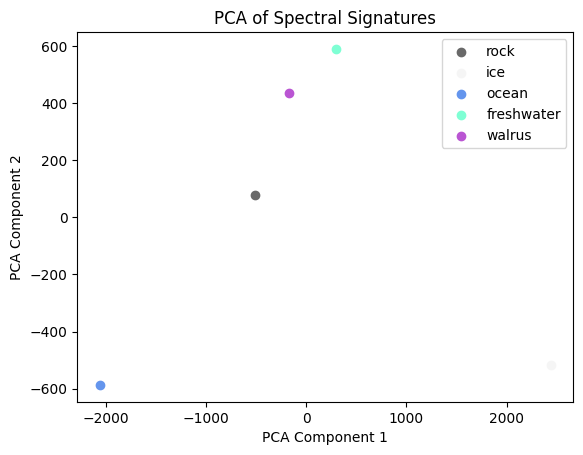

In [13]:
# Apply PCA for dimensionality reduction and visualization
all_signatures_combined = np.vstack([mean_spectral_signatures[cls] for cls in mean_spectral_signatures])
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(all_signatures_combined)

# Plot the PCA transformed spectral signatures
plt.figure()
for i, cls in enumerate(mean_spectral_signatures):
    plt.scatter(pca_transformed[i, 0], pca_transformed[i, 1], label=cls, color=label_colors[cls])
plt.legend()
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Spectral Signatures')
plt.show()

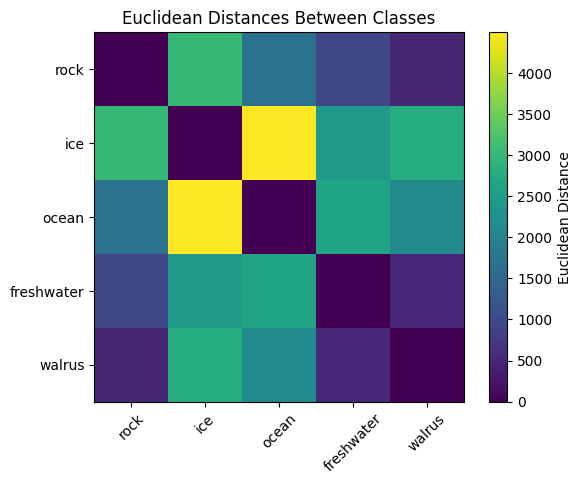

In [14]:
# Plot Euclidean distances as a heatmap
plt.figure()
plt.imshow(distances, cmap='viridis', interpolation='none')
plt.colorbar(label='Euclidean Distance')
plt.xticks(range(len(classes)), classes, rotation=45)
plt.yticks(range(len(classes)), classes)
plt.title('Euclidean Distances Between Classes')
plt.show()

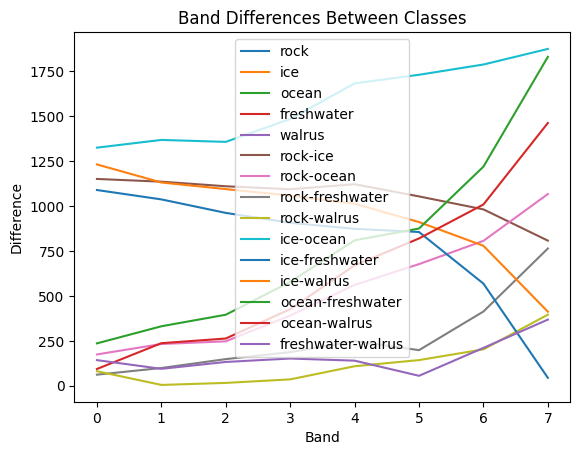

In [15]:
# Plot band differences for each class pair
plt.figure()
for key, value in band_differences.items():
    plt.plot(value, label=key)
plt.legend()
plt.xlabel('Band')
plt.ylabel('Difference')
plt.title('Band Differences Between Classes')
plt.show()

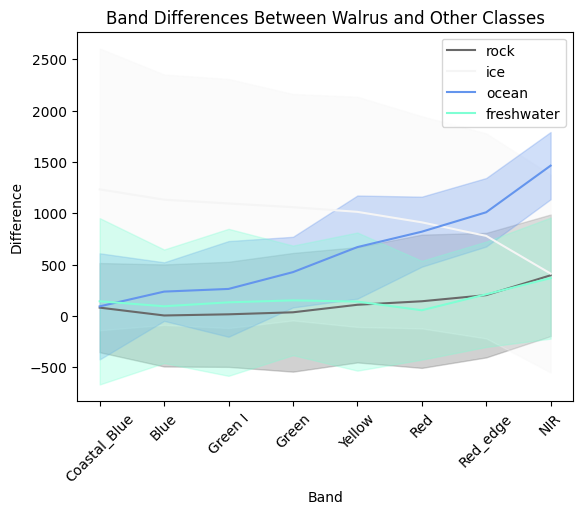

In [17]:
# Calculate mean spectral signature and standard deviation for each class
mean_spectral_signatures = {}
std_spectral_signatures = {}
for cls, signatures in all_spectral_signatures.items():
    if signatures:
        mean_spectral_signatures[cls] = np.mean(signatures, axis=0)
        std_spectral_signatures[cls] = np.std(signatures, axis=0)

# Combine walrus_pure and walrus_mixed into one class
walrus_signatures = []
walrus_std_signatures = []
if 'walrus_pure' in mean_spectral_signatures:
    walrus_signatures.append(mean_spectral_signatures.pop('walrus_pure'))
    walrus_std_signatures.append(std_spectral_signatures.pop('walrus_pure'))
if 'walrus_mixed' in mean_spectral_signatures:
    walrus_signatures.append(mean_spectral_signatures.pop('walrus_mixed'))
    walrus_std_signatures.append(std_spectral_signatures.pop('walrus_mixed'))

if walrus_signatures:
    mean_spectral_signatures['walrus'] = np.mean(walrus_signatures, axis=0)
    std_spectral_signatures['walrus'] = np.sqrt(np.mean(np.array(walrus_std_signatures) ** 2, axis=0))

# Calculate band differences and errors across the classes, comparing with walrus class
def calculate_band_differences_with_walrus(mean_spectral_signatures, std_spectral_signatures):
    walrus_signature = mean_spectral_signatures['walrus']
    walrus_std = std_spectral_signatures['walrus']
    band_differences = {}
    error_values = {}
    for cls, signature in mean_spectral_signatures.items():
        if cls != 'walrus':
            difference = np.abs(walrus_signature - signature)
            error = np.sqrt(walrus_std ** 2 + std_spectral_signatures[cls] ** 2)
            band_differences[cls] = difference
            error_values[cls] = error
    return band_differences, error_values

band_differences, error_values = calculate_band_differences_with_walrus(mean_spectral_signatures, std_spectral_signatures)

# Define band labels
band_labels = ['Coastal_Blue', 'Blue', 'Green I', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']

# Plot band differences for each class against walrus with error bars
plt.figure()
for cls, value in band_differences.items():
    plt.plot(value, label=cls, color=label_colors[cls])
    plt.fill_between(range(len(value)), value - error_values[cls], value + error_values[cls], color=label_colors[cls], alpha=0.3)

plt.legend()
plt.xticks(range(len(band_labels)), band_labels, rotation=45)
plt.xlabel('Band')
plt.ylabel('Difference')
plt.title('Band Differences Between Walrus and Other Classes')
plt.show()


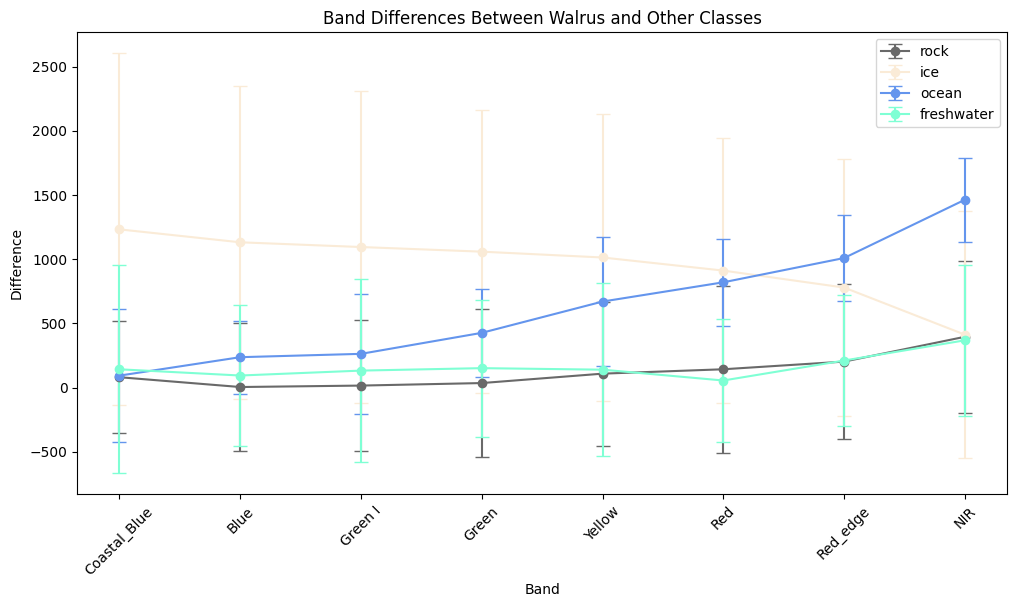

In [24]:
# Assuming all_spectral_signatures dictionary is already populated with spectral signatures
# Calculate mean spectral signature and standard deviation for each class
mean_spectral_signatures = {}
std_spectral_signatures = {}
for cls, signatures in all_spectral_signatures.items():
    if signatures:
        mean_spectral_signatures[cls] = np.mean(signatures, axis=0)
        std_spectral_signatures[cls] = np.std(signatures, axis=0)

# Combine walrus_pure and walrus_mixed into one class
walrus_signatures = []
walrus_std_signatures = []
if 'walrus_pure' in mean_spectral_signatures:
    walrus_signatures.append(mean_spectral_signatures.pop('walrus_pure'))
    walrus_std_signatures.append(std_spectral_signatures.pop('walrus_pure'))
if 'walrus_mixed' in mean_spectral_signatures:
    walrus_signatures.append(mean_spectral_signatures.pop('walrus_mixed'))
    walrus_std_signatures.append(std_spectral_signatures.pop('walrus_mixed'))

if walrus_signatures:
    mean_spectral_signatures['walrus'] = np.mean(walrus_signatures, axis=0)
    std_spectral_signatures['walrus'] = np.sqrt(np.mean(np.array(walrus_std_signatures) ** 2, axis=0))

# Calculate band differences and errors across the classes, comparing with walrus class
def calculate_band_differences_with_walrus(mean_spectral_signatures, std_spectral_signatures):
    walrus_signature = mean_spectral_signatures['walrus']
    walrus_std = std_spectral_signatures['walrus']
    band_differences = {}
    error_values = {}
    for cls, signature in mean_spectral_signatures.items():
        if cls != 'walrus':
            difference = np.abs(walrus_signature - signature)
            error = np.sqrt(walrus_std ** 2 + std_spectral_signatures[cls] ** 2)
            band_differences[cls] = difference
            error_values[cls] = error
    return band_differences, error_values

band_differences, error_values = calculate_band_differences_with_walrus(mean_spectral_signatures, std_spectral_signatures)

# Define band labels
band_labels = ['Coastal_Blue', 'Blue', 'Green I', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']

# Define the color mapping for each class
label_colors = {
    'ice': 'antiquewhite',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine'
}

# Plot band differences for each class against walrus with error bars
plt.figure(figsize=(12, 6))
for cls, value in band_differences.items():
    plt.errorbar(range(len(value)), value, yerr=error_values[cls], label=cls, color=label_colors[cls], fmt='-o', capsize=5)

plt.legend()
plt.xticks(range(len(band_labels)), band_labels, rotation=45)
plt.xlabel('Band')
plt.ylabel('Difference')
plt.title('Band Differences Between Walrus and Other Classes')
plt.show()


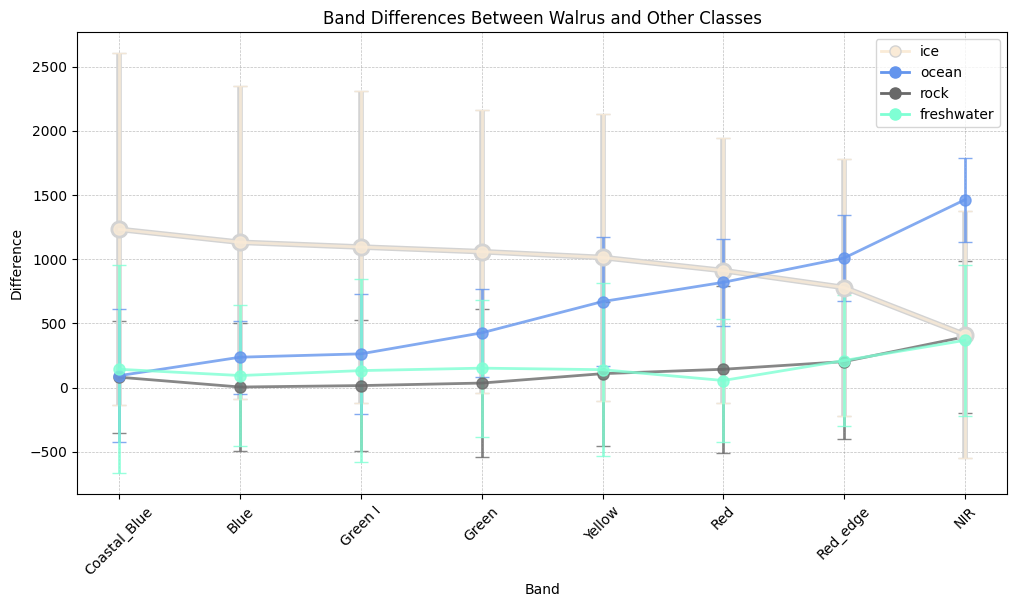

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Assuming all_spectral_signatures dictionary is already populated with spectral signatures
# Calculate mean spectral signature and standard deviation for each class
mean_spectral_signatures = {}
std_spectral_signatures = {}
for cls, signatures in all_spectral_signatures.items():
    if signatures:
        mean_spectral_signatures[cls] = np.mean(signatures, axis=0)
        std_spectral_signatures[cls] = np.std(signatures, axis=0)

# Combine walrus_pure and walrus_mixed into one class
walrus_signatures = []
walrus_std_signatures = []
if 'walrus_pure' in mean_spectral_signatures:
    walrus_signatures.append(mean_spectral_signatures.pop('walrus_pure'))
    walrus_std_signatures.append(std_spectral_signatures.pop('walrus_pure'))
if 'walrus_mixed' in mean_spectral_signatures:
    walrus_signatures.append(mean_spectral_signatures.pop('walrus_mixed'))
    walrus_std_signatures.append(std_spectral_signatures.pop('walrus_mixed'))

if walrus_signatures:
    mean_spectral_signatures['walrus'] = np.mean(walrus_signatures, axis=0)
    std_spectral_signatures['walrus'] = np.sqrt(np.mean(np.array(walrus_std_signatures) ** 2, axis=0))

# Calculate band differences and errors across the classes, comparing with walrus class
def calculate_band_differences_with_walrus(mean_spectral_signatures, std_spectral_signatures):
    walrus_signature = mean_spectral_signatures['walrus']
    walrus_std = std_spectral_signatures['walrus']
    band_differences = {}
    error_values = {}
    for cls, signature in mean_spectral_signatures.items():
        if cls != 'walrus':
            difference = np.abs(walrus_signature - signature)
            error = np.sqrt(walrus_std ** 2 + std_spectral_signatures[cls] ** 2)
            band_differences[cls] = difference
            error_values[cls] = error
    return band_differences, error_values

band_differences, error_values = calculate_band_differences_with_walrus(mean_spectral_signatures, std_spectral_signatures)

# Define band labels
band_labels = ['Coastal_Blue', 'Blue', 'Green I', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']

# Define the color mapping for each class
label_colors = {
    'ice': 'antiquewhite',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine'
}

# Plot band differences for each class against walrus with error bars
plt.figure(figsize=(12, 6))

# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)

# Plot the classes
for cls, value in band_differences.items():
    if cls == 'ice':
        # Plot the lightgrey outline for the ice class
        plt.errorbar(range(len(value)), value, yerr=error_values[cls], fmt='-o', color='lightgrey', capsize=5, linewidth=4, markersize=12, alpha=1)
        # Plot the main ice class line with the specified color
        plt.errorbar(range(len(value)), value, yerr=error_values[cls], fmt='-o', color=label_colors[cls], capsize=5, linewidth=2, markersize=8, alpha=0.8)
    else:
        plt.errorbar(range(len(value)), value, yerr=error_values[cls], label=cls, color=label_colors[cls], fmt='-o', capsize=5, linewidth=2, markersize=8, alpha=0.8)

# Add proxy artist for the ice class in the legend
legend_elements = [
    Line2D([0], [0], color='antiquewhite', markerfacecolor='antiquewhite', markeredgecolor='lightgrey', lw=2, marker='o', markersize=8, label='ice'),
    Line2D([0], [0], color='cornflowerblue', lw=2, marker='o', markersize=8, label='ocean'),
    Line2D([0], [0], color='dimgrey', lw=2, marker='o', markersize=8, label='rock'),
    Line2D([0], [0], color='aquamarine', lw=2, marker='o', markersize=8, label='freshwater')
]
plt.legend(handles=legend_elements)

plt.xticks(range(len(band_labels)), band_labels, rotation=45)
plt.xlabel('Band')
plt.ylabel('Difference')
plt.title('Band Differences Between Walrus and Other Classes')
plt.show()


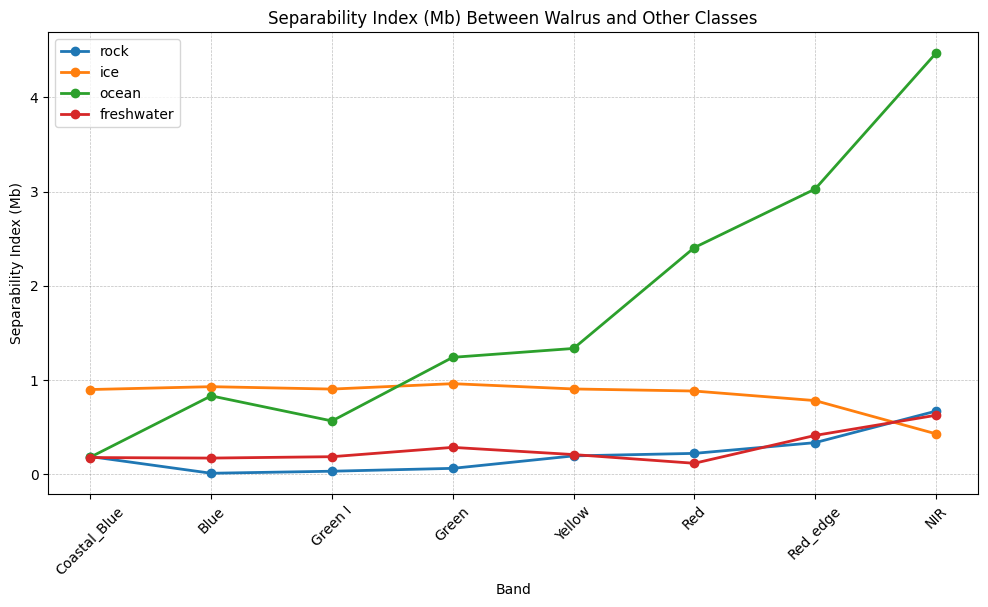

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming mean_spectral_signatures and std_spectral_signatures are already populated
# Define band labels
band_labels = ['Coastal_Blue', 'Blue', 'Green I', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']

# Calculate the separability index
def calculate_separability_index_mb(mean_spectral_signatures, std_spectral_signatures):
    walrus_mean = mean_spectral_signatures['walrus']
    walrus_std = std_spectral_signatures['walrus']
    
    separability_indices = {}
    for cls, cls_mean in mean_spectral_signatures.items():
        if cls != 'walrus':
            cls_std = std_spectral_signatures[cls]
            Mb = np.abs(walrus_mean - cls_mean) / np.sqrt(walrus_std**2 + cls_std**2)
            separability_indices[cls] = Mb
    return separability_indices

separability_indices_mb = calculate_separability_index_mb(mean_spectral_signatures, std_spectral_signatures)

# Plot the separability index for each band
plt.figure(figsize=(12, 6))
for cls, indices in separability_indices_mb.items():
    plt.plot(range(len(indices)), indices, label=cls, marker='o', linestyle='-', linewidth=2)

plt.legend()
plt.xticks(range(len(band_labels)), band_labels, rotation=45)
plt.xlabel('Band')
plt.ylabel('Separability Index (Mb)')
plt.title('Separability Index (Mb) Between Walrus and Other Classes')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.show()


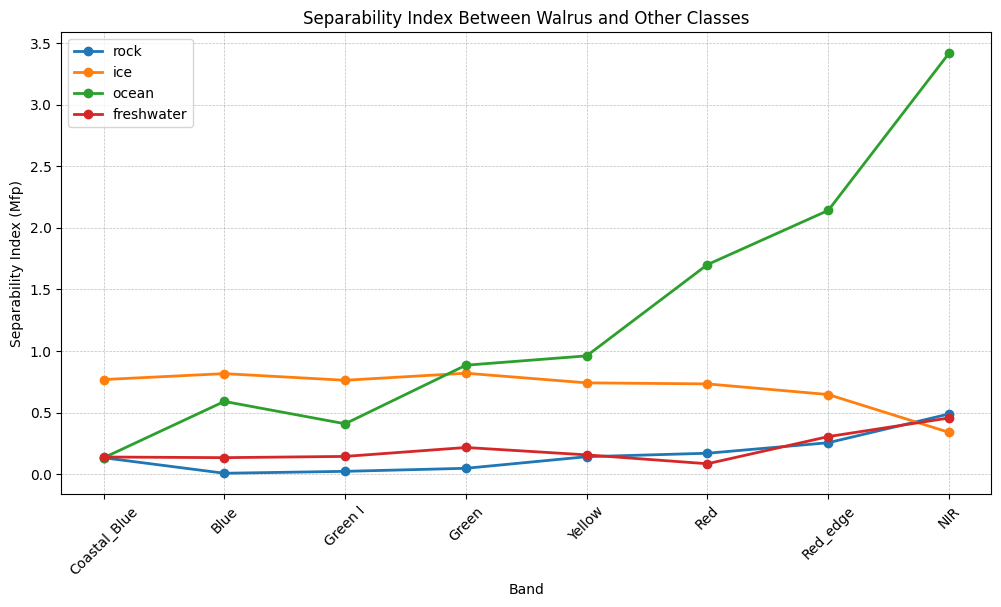

In [30]:
# Assuming mean_spectral_signatures and std_spectral_signatures are already populated
# Define band labels
band_labels = ['Coastal_Blue', 'Blue', 'Green I', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']

# Calculate the separability index
def calculate_separability_index(mean_spectral_signatures, std_spectral_signatures):
    walrus_mean = mean_spectral_signatures['walrus']
    walrus_std = std_spectral_signatures['walrus']
    
    separability_indices = {}
    for cls, cls_mean in mean_spectral_signatures.items():
        if cls != 'walrus':
            cls_std = std_spectral_signatures[cls]
            Mfp = np.abs(walrus_mean - cls_mean) / (walrus_std + cls_std)
            separability_indices[cls] = Mfp
    return separability_indices

separability_indices = calculate_separability_index(mean_spectral_signatures, std_spectral_signatures)

# Plot the separability index for each band
plt.figure(figsize=(12, 6))
for cls, indices in separability_indices.items():
    plt.plot(range(len(indices)), indices, label=cls, marker='o', linestyle='-', linewidth=2)

plt.legend()
plt.xticks(range(len(band_labels)), band_labels, rotation=45)
plt.xlabel('Band')
plt.ylabel('Separability Index (Mfp)')
plt.title('Separability Index Between Walrus and Other Classes')
plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
plt.show()


In [38]:
for class_name in ['rock', 'ice', 'ocean', 'freshwater']:
    if class_name in separability_indices_mb:
        print(f"Class: {class_name}, Data shape: {np.shape(separability_indices_mb[class_name])}")
    else:
        print(f"Class: {class_name} is not present in separability_indices_mb")

Class: rock, Data shape: (8,)
Class: ice, Data shape: (8,)
Class: ocean, Data shape: (8,)
Class: freshwater, Data shape: (8,)


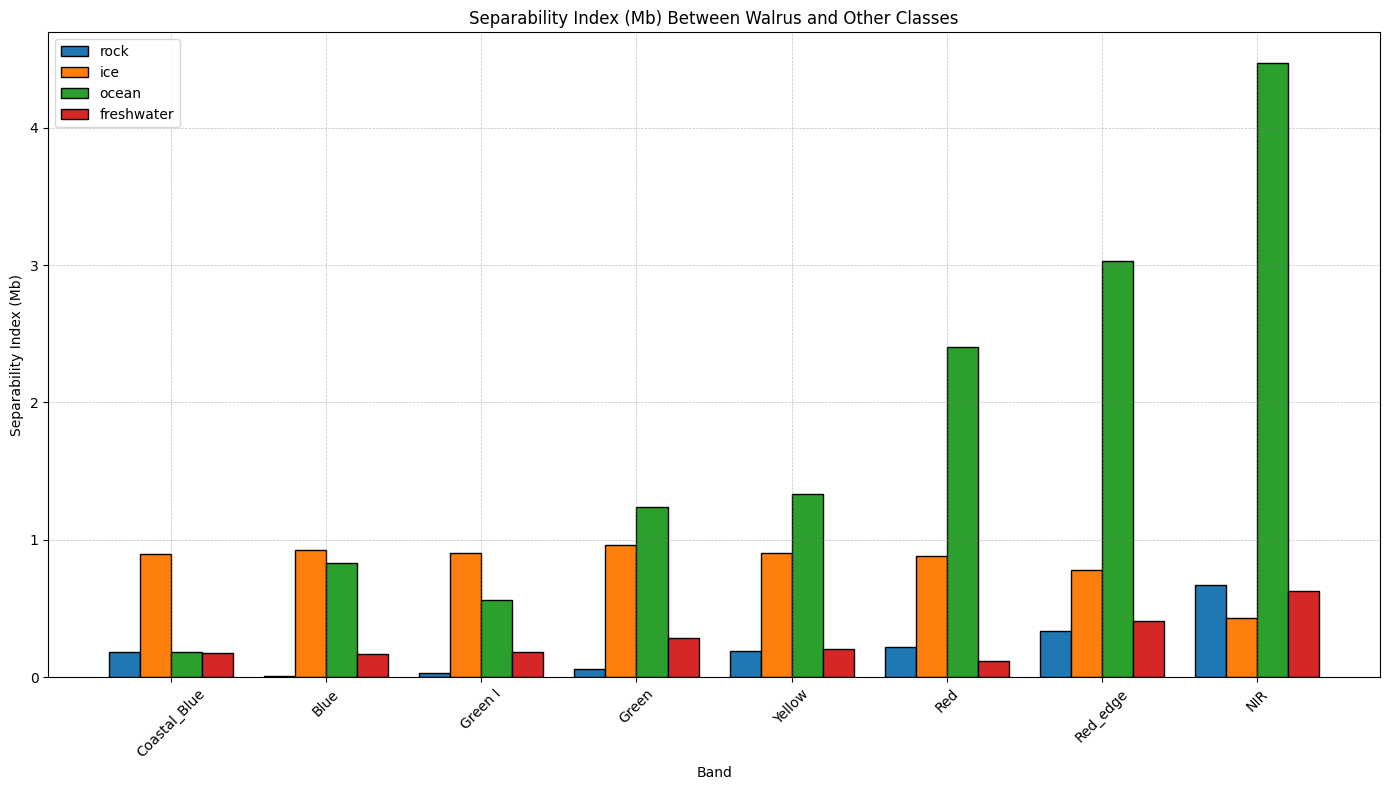

In [39]:
def plot_all_separability_bar(separability_indices, band_labels, class_names):
    plt.figure(figsize=(14, 8))
    x = np.arange(len(band_labels))
    width = 0.2
    
    for i, class_name in enumerate(class_names):
        plt.bar(x + i*width, separability_indices[class_name], width, label=class_name, edgecolor='black')
    
    plt.xlabel('Band')
    plt.ylabel('Separability Index (Mb)')
    plt.title('Separability Index (Mb) Between Walrus and Other Classes')
    plt.xticks(x + width*1.5, band_labels, rotation=45)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Use it like this:
class_names = ['rock', 'ice', 'ocean', 'freshwater']
plot_all_separability_bar(separability_indices_mb, band_labels, class_names)

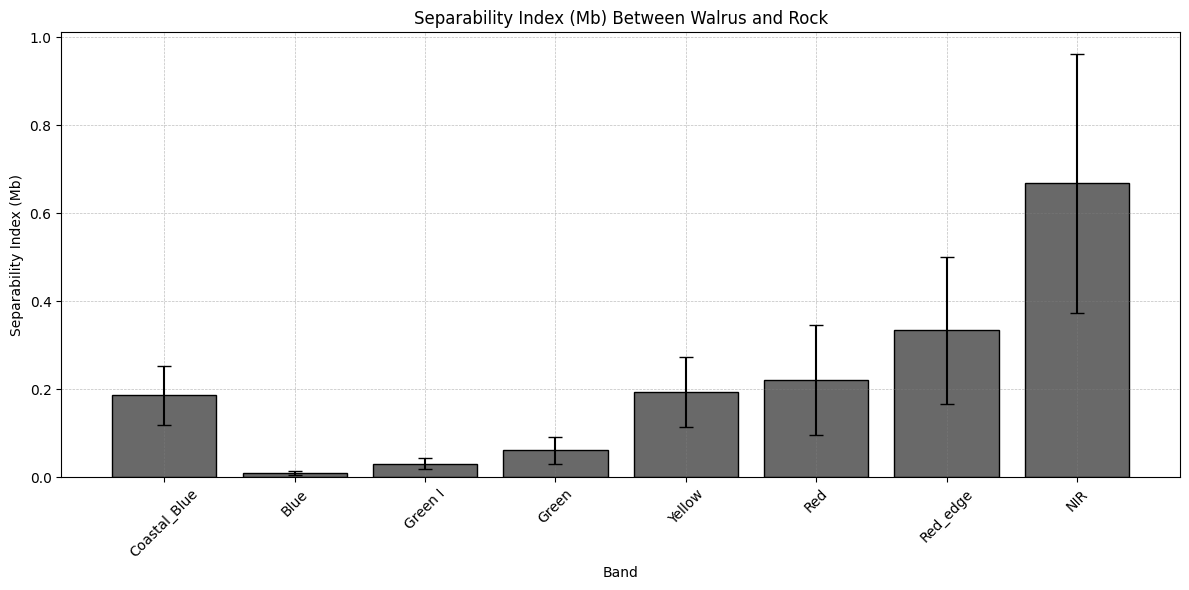

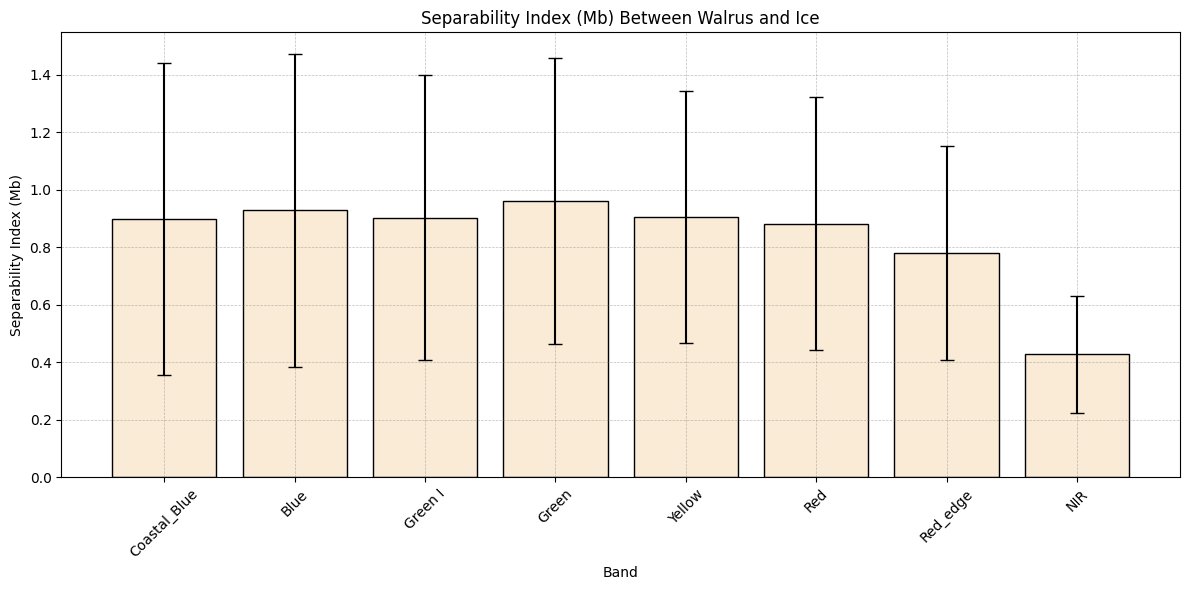

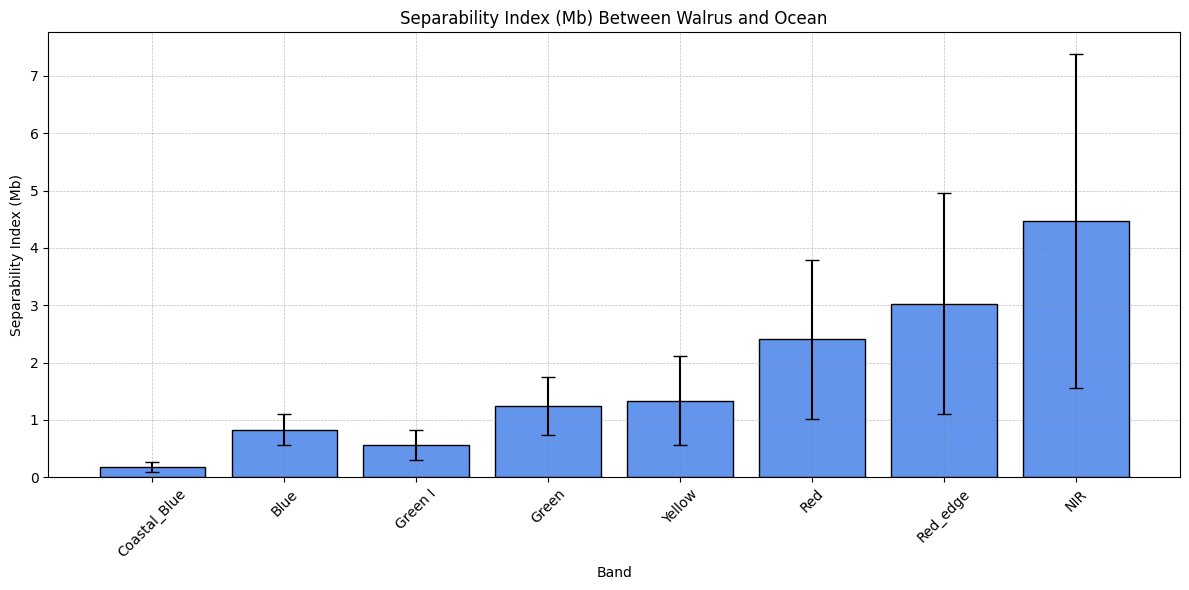

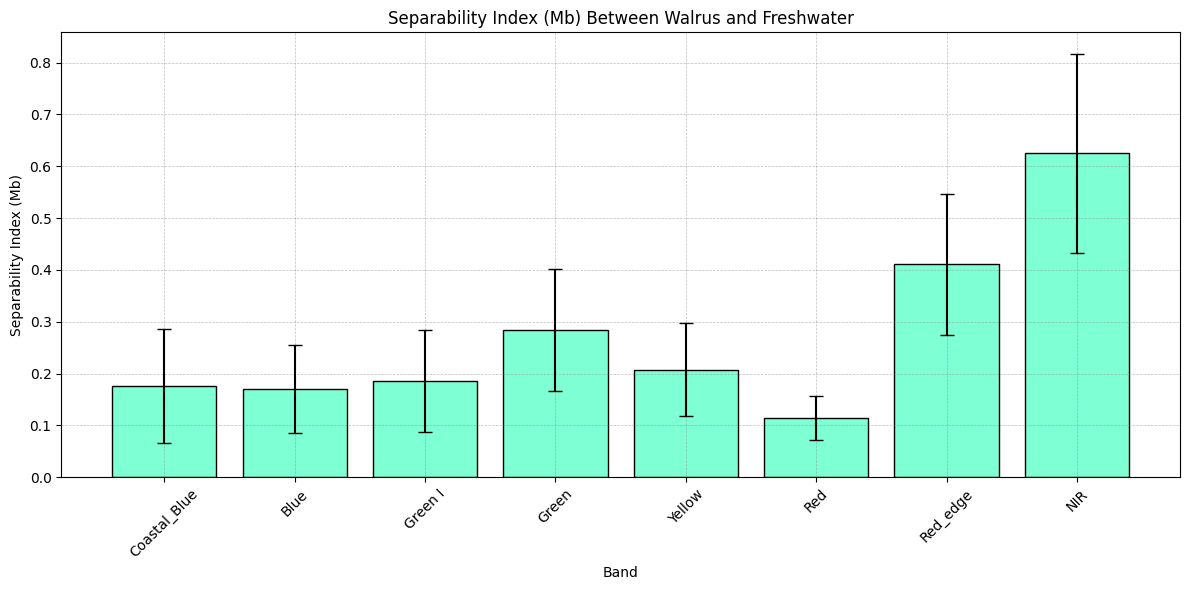

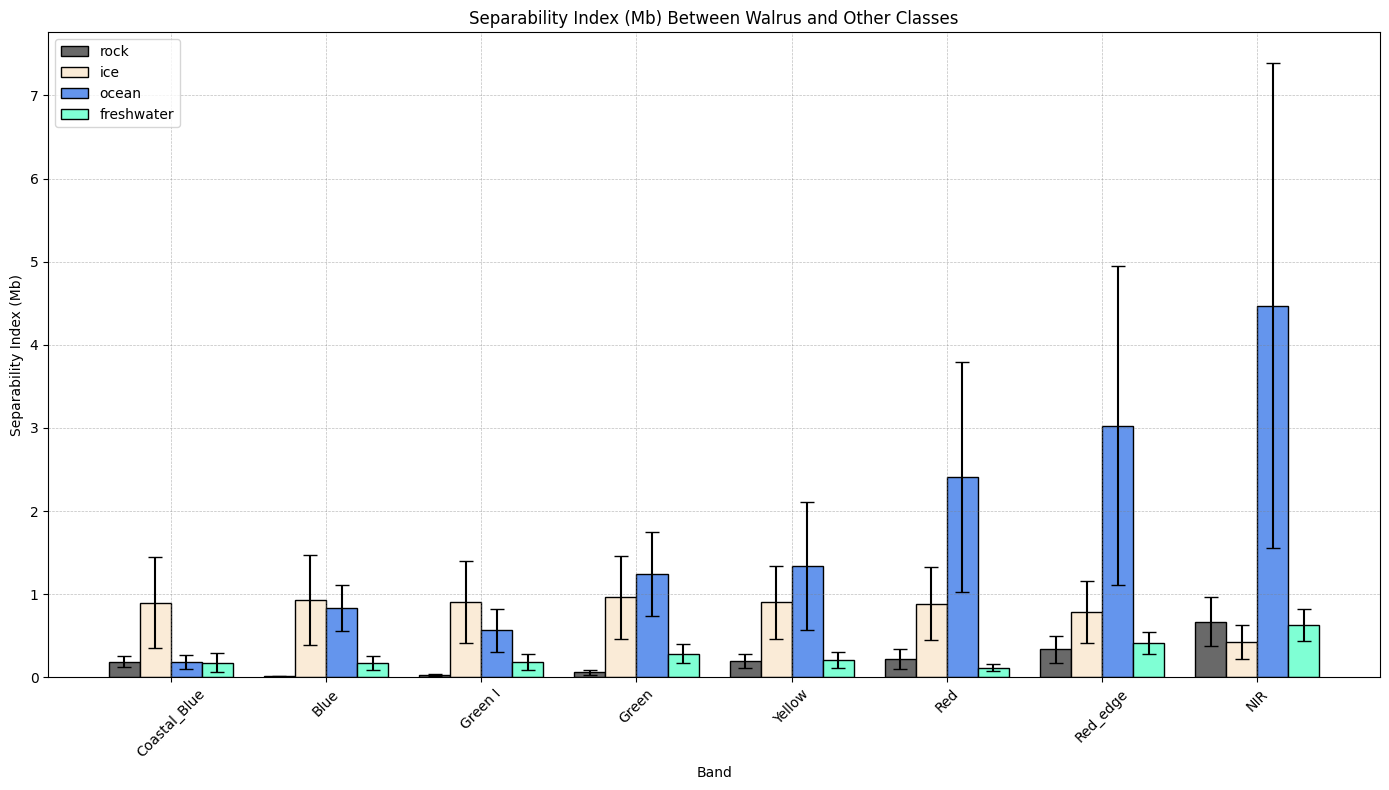

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Define band labels
band_labels = ['Coastal_Blue', 'Blue', 'Green I', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']

# Define the color mapping for each class
label_colors = {
    'ice': 'antiquewhite',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine'
}

def calculate_separability_index_mb(mean_spectral_signatures, std_spectral_signatures):
    walrus_mean = mean_spectral_signatures['walrus']
    walrus_std = std_spectral_signatures['walrus']
    
    separability_indices = {}
    separability_errors = {}
    for cls in ['rock', 'ice', 'ocean', 'freshwater']:
        cls_mean = mean_spectral_signatures[cls]
        cls_std = std_spectral_signatures[cls]
        
        Mb = np.abs(walrus_mean - cls_mean) / np.sqrt(walrus_std**2 + cls_std**2)
        separability_indices[cls] = Mb
        
        # Calculate standard error of Mb using error propagation
        Mb_se = Mb * np.sqrt((walrus_std/walrus_mean)**2 + (cls_std/cls_mean)**2)
        separability_errors[cls] = Mb_se
    
    return separability_indices, separability_errors

separability_indices_mb, separability_errors_mb = calculate_separability_index_mb(mean_spectral_signatures, std_spectral_signatures)

def plot_separability_bar_with_error(class_name, separability_indices, separability_errors, band_labels):
    plt.figure(figsize=(12, 6))
    data = separability_indices[class_name]
    errors = separability_errors[class_name]
    
    plt.bar(band_labels, data, color=label_colors[class_name], edgecolor='black', yerr=errors, capsize=5)

    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
    plt.xticks(rotation=45)
    plt.xlabel('Band')
    plt.ylabel('Separability Index (Mb)')
    plt.title(f'Separability Index (Mb) Between Walrus and {class_name.capitalize()}')
    plt.tight_layout()
    plt.show()

# Plot for each class
for class_name in ['rock', 'ice', 'ocean', 'freshwater']:
    plot_separability_bar_with_error(class_name, separability_indices_mb, separability_errors_mb, band_labels)

def plot_all_separability_bar_with_error(separability_indices, separability_errors, band_labels, class_names):
    plt.figure(figsize=(14, 8))
    x = np.arange(len(band_labels))
    width = 0.2
    
    for i, class_name in enumerate(class_names):
        plt.bar(x + i*width, separability_indices[class_name], width, 
                label=class_name, color=label_colors[class_name], edgecolor='black',
                yerr=separability_errors[class_name], capsize=5)
    
    plt.xlabel('Band')
    plt.ylabel('Separability Index (Mb)')
    plt.title('Separability Index (Mb) Between Walrus and Other Classes')
    plt.xticks(x + width*1.5, band_labels, rotation=45)
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Plot all classes in one graph
class_names = ['rock', 'ice', 'ocean', 'freshwater']
plot_all_separability_bar_with_error(separability_indices_mb, separability_errors_mb, band_labels, class_names)

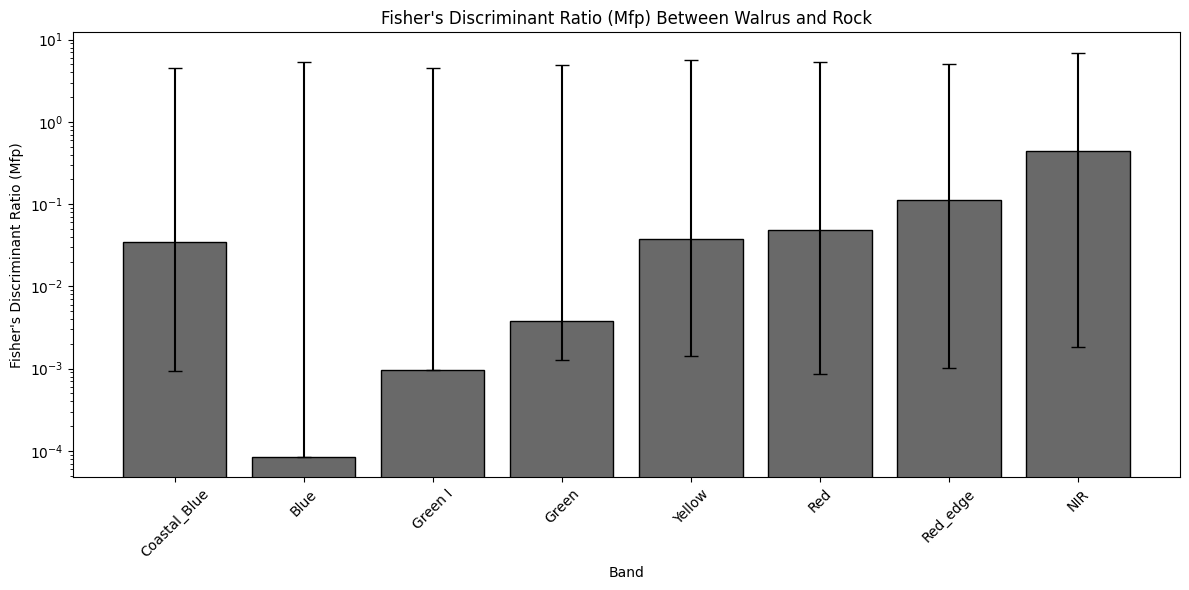

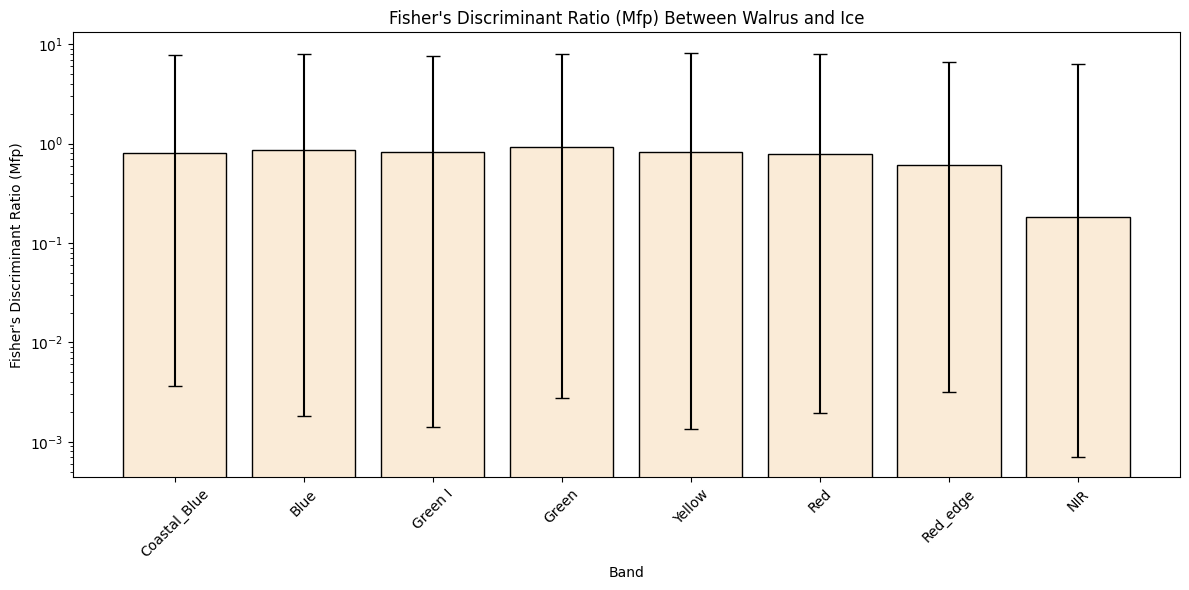

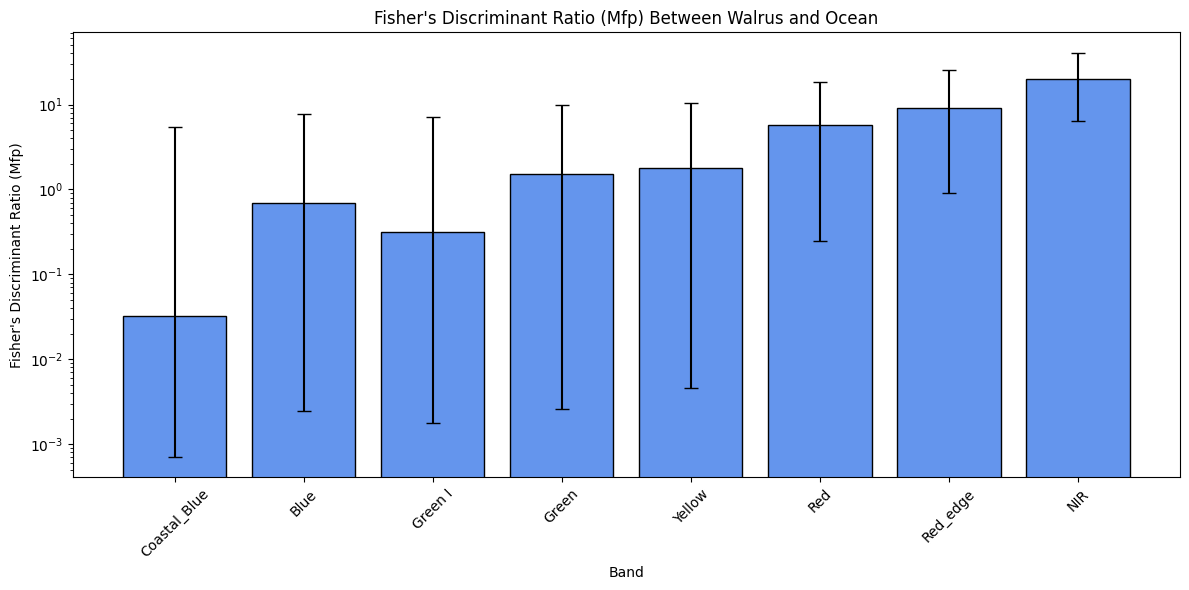

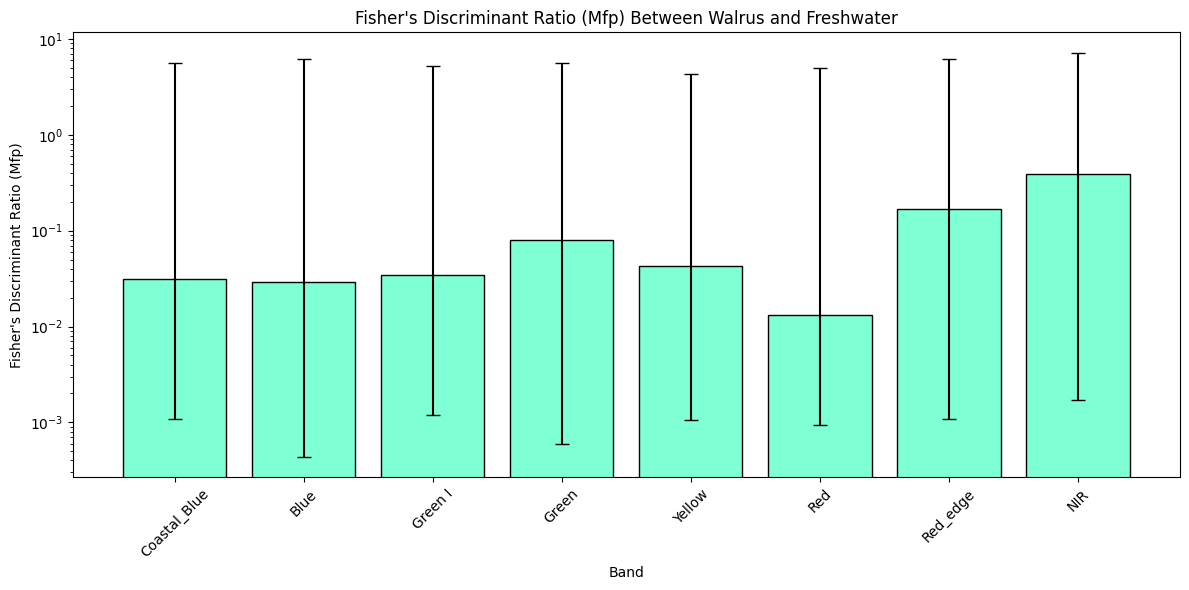

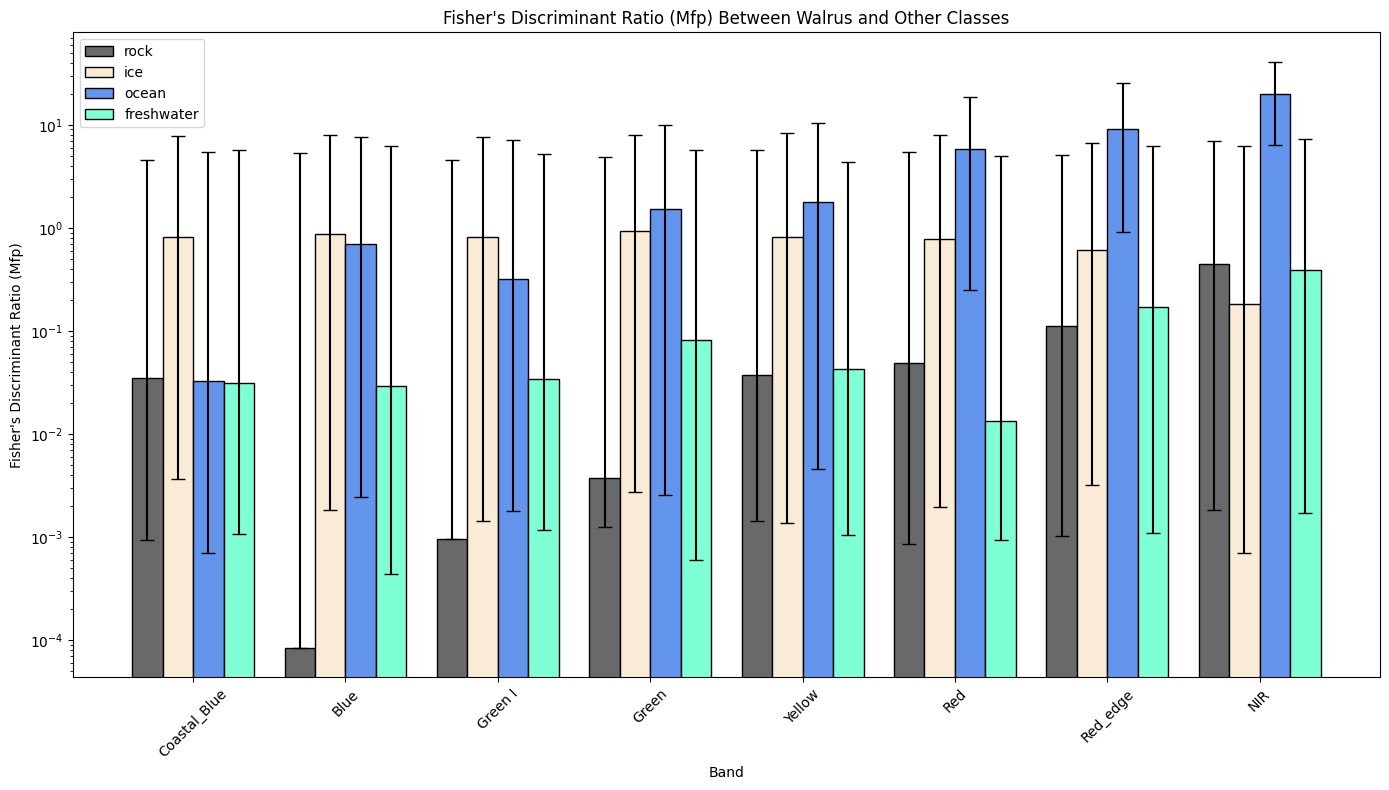

In [49]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Define band labels
band_labels = ['Coastal_Blue', 'Blue', 'Green I', 'Green', 'Yellow', 'Red', 'Red_edge', 'NIR']

# Define the color mapping for each class
label_colors = {
    'ice': 'antiquewhite',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine'
}

# Function to calculate Fisher's Discriminant Ratio (Mfp) with bootstrap error estimation
def calculate_fisher_discriminant_ratio(mean_spectral_signatures, std_spectral_signatures, n_bootstrap=1000):
    walrus_mean = mean_spectral_signatures['walrus']
    walrus_std = std_spectral_signatures['walrus']
    
    fisher_indices = {}
    fisher_errors_lower = {}
    fisher_errors_upper = {}
    
    for cls in ['rock', 'ice', 'ocean', 'freshwater']:
        cls_mean = mean_spectral_signatures[cls]
        cls_std = std_spectral_signatures[cls]
        
        Mfp = (walrus_mean - cls_mean)**2 / (walrus_std**2 + cls_std**2)
        fisher_indices[cls] = Mfp
        
        # Bootstrap to estimate confidence intervals
        bootstrap_Mfps = []
        for _ in range(n_bootstrap):
            walrus_sample = np.random.normal(walrus_mean, walrus_std)
            cls_sample = np.random.normal(cls_mean, cls_std)
            bootstrap_Mfp = (walrus_sample - cls_sample)**2 / (walrus_std**2 + cls_std**2)
            bootstrap_Mfps.append(bootstrap_Mfp)
        
        lower, upper = np.percentile(bootstrap_Mfps, [2.5, 97.5], axis=0)
        fisher_errors_lower[cls] = np.maximum(Mfp - lower, 0)  # Ensure non-negative
        fisher_errors_upper[cls] = np.maximum(upper - Mfp, 0)  # Ensure non-negative
    
    return fisher_indices, fisher_errors_lower, fisher_errors_upper

# Function to plot Fisher's Discriminant Ratio (Mfp) with asymmetric error bars
def plot_fisher_discriminant_ratio(class_name, fisher_indices, fisher_errors_lower, fisher_errors_upper, band_labels):
    plt.figure(figsize=(12, 6))
    data = fisher_indices[class_name]
    errors = [fisher_errors_lower[class_name], fisher_errors_upper[class_name]]
    
    plt.bar(band_labels, data, color=label_colors[class_name], edgecolor='black')
    plt.errorbar(band_labels, data, yerr=errors, fmt='none', capsize=5, color='black')
    plt.yscale('log')  # Use log scale for better visualization
    plt.grid(False)  # Disable grid
    plt.xticks(rotation=45)
    plt.xlabel('Band')
    plt.ylabel('Fisher\'s Discriminant Ratio (Mfp)')
    plt.title(f'Fisher\'s Discriminant Ratio (Mfp) Between Walrus and {class_name.capitalize()}')
    plt.tight_layout()
    plt.gca().set_facecolor('white')  # Ensure the background is white
    plt.show()

# Function to plot all Fisher's Discriminant Ratios (Mfp) in one graph
def plot_all_fisher_discriminant_ratios(fisher_indices, fisher_errors_lower, fisher_errors_upper, band_labels, class_names):
    plt.figure(figsize=(14, 8))
    x = np.arange(len(band_labels))
    width = 0.2
    
    for i, class_name in enumerate(class_names):
        plt.bar(x + i*width, fisher_indices[class_name], width, 
                label=class_name, color=label_colors[class_name], edgecolor='black')
        plt.errorbar(x + i*width, fisher_indices[class_name], 
                     yerr=[fisher_errors_lower[class_name], fisher_errors_upper[class_name]], 
                     fmt='none', capsize=5, color='black')
    
    plt.xlabel('Band')
    plt.ylabel('Fisher\'s Discriminant Ratio (Mfp)')
    plt.title('Fisher\'s Discriminant Ratio (Mfp) Between Walrus and Other Classes')
    plt.xticks(x + width*1.5, band_labels, rotation=45)
    plt.legend()
    plt.yscale('log')  # Use log scale for better visualization
    plt.grid(False)  # Disable grid
    plt.tight_layout()
    plt.gca().set_facecolor('white')  # Ensure the background is white
    plt.show()

# Main execution
# Note: You need to define mean_spectral_signatures and std_spectral_signatures before this point

# Calculate Fisher's Discriminant Ratio and errors
fisher_indices, fisher_errors_lower, fisher_errors_upper = calculate_fisher_discriminant_ratio(mean_spectral_signatures, std_spectral_signatures)

# Plot Fisher's Discriminant Ratio (Mfp) for each class
for class_name in ['rock', 'ice', 'ocean', 'freshwater']:
    plot_fisher_discriminant_ratio(class_name, fisher_indices, fisher_errors_lower, fisher_errors_upper, band_labels)

# Plot all classes in one graph
class_names = ['rock', 'ice', 'ocean', 'freshwater']
plot_all_fisher_discriminant_ratios(fisher_indices, fisher_errors_lower, fisher_errors_upper, band_labels, class_names)


In [50]:
# Print separability indices Mb and their errors
for cls in ['rock', 'ice', 'ocean', 'freshwater']:
    print(f"Separability Index Mb between Walrus and {cls.capitalize()}:")
    for band, value in zip(band_labels, separability_indices_mb[cls]):
        print(f"{band}: {value:.4f} ± {separability_errors_mb[cls][band_labels.index(band)]:.4f}")
    print("\n")

# Print Fisher's Discriminant Ratio Mfp and their errors
for cls in ['rock', 'ice', 'ocean', 'freshwater']:
    print(f"Fisher's Discriminant Ratio Mfp between Walrus and {cls.capitalize()}:")
    for band, value in zip(band_labels, fisher_indices[cls]):
        lower_error = fisher_errors_lower[cls][band_labels.index(band)]
        upper_error = fisher_errors_upper[cls][band_labels.index(band)]
        print(f"{band}: {value:.4f} (lower error: {lower_error:.4f}, upper error: {upper_error:.4f})")
    print("\n")


Separability Index Mb between Walrus and Rock:
Coastal_Blue: 0.1863 ± 0.0668
Blue: 0.0092 ± 0.0045
Green I: 0.0309 ± 0.0130
Green: 0.0613 ± 0.0311
Yellow: 0.1937 ± 0.0805
Red: 0.2203 ± 0.1253
Red_edge: 0.3342 ± 0.1667
NIR: 0.6690 ± 0.2945


Separability Index Mb between Walrus and Ice:
Coastal_Blue: 0.8985 ± 0.5436
Blue: 0.9287 ± 0.5454
Green I: 0.9032 ± 0.4960
Green: 0.9606 ± 0.4972
Yellow: 0.9046 ± 0.4391
Red: 0.8825 ± 0.4400
Red_edge: 0.7809 ± 0.3730
NIR: 0.4283 ± 0.2039


Separability Index Mb between Walrus and Ocean:
Coastal_Blue: 0.1808 ± 0.0857
Blue: 0.8312 ± 0.2754
Green I: 0.5646 ± 0.2561
Green: 1.2404 ± 0.5054
Yellow: 1.3347 ± 0.7718
Red: 2.4056 ± 1.3832
Red_edge: 3.0277 ± 1.9234
NIR: 4.4697 ± 2.9193


Separability Index Mb between Walrus and Freshwater:
Coastal_Blue: 0.1761 ± 0.1108
Blue: 0.1704 ± 0.0853
Green I: 0.1851 ± 0.0985
Green: 0.2841 ± 0.1171
Yellow: 0.2077 ± 0.0904
Red: 0.1151 ± 0.0423
Red_edge: 0.4109 ± 0.1359
NIR: 0.6251 ± 0.1925


Fisher's Discriminant Ratio Mf

In [52]:
import numpy as np
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

def jeffries_matusita_distance(mean1, cov1, mean2, cov2):
    diff = mean1 - mean2
    cov_mean = (cov1 + cov2) / 2
    return 2 * (1 - np.exp(-0.125 * np.dot(np.dot(diff.T, np.linalg.inv(cov_mean)), diff)))

def bhattacharyya_distance(mean1, cov1, mean2, cov2):
    diff = mean1 - mean2
    cov_mean = (cov1 + cov2) / 2
    cov1 += np.eye(cov1.shape[0]) * 1e-6  # Add small value to diagonal
    cov2 += np.eye(cov2.shape[0]) * 1e-6  # Add small value to diagonal
    term1 = 0.25 * np.dot(np.dot(diff.T, np.linalg.inv(cov_mean)), diff)
    term2 = 0.5 * np.log(np.linalg.det(cov_mean) / np.sqrt(np.linalg.det(cov1) * np.linalg.det(cov2)))
    return term1 + term2


def compare_spectral_signatures(data, labels):
    classes = np.unique(labels)
    n_classes = len(classes)
    n_features = data.shape[1]
    
    # Fisher's Discriminant Ratio
    fdr = np.zeros((n_classes, n_classes, n_features))
    for i in range(n_classes):
        for j in range(i+1, n_classes):
            class_i = data[labels == classes[i]]
            class_j = data[labels == classes[j]]
            fdr[i, j] = ((np.mean(class_i, axis=0) - np.mean(class_j, axis=0))**2 /
                         (np.var(class_i, axis=0) + np.var(class_j, axis=0)))
    
    # Jeffries-Matusita Distance and Bhattacharyya Distance
    jm_distance = np.zeros((n_classes, n_classes))
    bhattacharyya_dist = np.zeros((n_classes, n_classes))
    for i in range(n_classes):
        for j in range(i+1, n_classes):
            class_i = data[labels == classes[i]]
            class_j = data[labels == classes[j]]
            jm_distance[i, j] = jeffries_matusita_distance(
                np.mean(class_i, axis=0), np.cov(class_i.T),
                np.mean(class_j, axis=0), np.cov(class_j.T)
            )
            bhattacharyya_dist[i, j] = bhattacharyya_distance(
                np.mean(class_i, axis=0), np.cov(class_i.T),
                np.mean(class_j, axis=0), np.cov(class_j.T)
            )
    
    # ANOVA
    f_values, p_values = stats.f_oneway(*[data[labels == c] for c in classes])
    
    # Random Forest Feature Importance
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    rf_importance = rf.feature_importances_
    
    # Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    lda_coef = lda.coef_
    
    return {
        'fdr': fdr,
        'jm_distance': jm_distance,
        'bhattacharyya_distance': bhattacharyya_dist,
        'anova_f': f_values,
        'anova_p': p_values,
        'rf_importance': rf_importance,
        'lda_coef': lda_coef
    }

# Example usage:
# Assuming 'data' is your spectral data (n_samples, n_features)
# and 'labels' are the corresponding class labels
mean_spectral_signatures = {}
std_spectral_signatures = {}
all_spectral_signatures_combined = []
all_labels = []

for cls, signatures in all_spectral_signatures.items():
    if signatures:
        mean_spectral_signatures[cls] = np.mean(signatures, axis=0)
        std_spectral_signatures[cls] = np.std(signatures, axis=0)
        all_spectral_signatures_combined.extend(signatures)
        all_labels.extend([cls] * len(signatures))

all_spectral_signatures_combined = np.array(all_spectral_signatures_combined)
all_labels = np.array(all_labels)

results = compare_spectral_signatures(all_spectral_signatures_combined, all_labels)

# Print results
print("Fisher's Discriminant Ratio (FDR):")
print(results['fdr'])
print("\nJeffries-Matusita Distance (JM):")
print(results['jm_distance'])
print("\nBhattacharyya Distance (BD):")
print(results['bhattacharyya_distance'])
print("\nANOVA F-values:")
print(results['anova_f'])
print("\nANOVA p-values:")
print(results['anova_p'])
print("\nRandom Forest Feature Importance:")
print(results['rf_importance'])
print("\nLDA Coefficients:")
print(results['lda_coef'])


Fisher's Discriminant Ratio (FDR):
[[[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [4.94114579e-01 6.24575572e-01 4.99189031e-01 5.83405521e-01
   4.93833526e-01 6.19490407e-01 2.81820658e-01 1.77585158e-03]
  [7.05720306e-02 3.42653949e-01 2.59338675e-01 1.06338592e+00
   1.20798037e+00 3.29615457e+00 5.67577840e+00 1.23380644e+01]
  [5.34884144e-03 2.00741238e-02 3.39336478e-02 6.60016362e-02
   1.01843898e-01 7.31731615e-02 3.29539820e-01 1.13414940e+00]
  [2.18273186e-02 9.09992792e-03 1.55537408e-02 2.86333067e-02
   1.75876676e-02 6.21865819e-05 1.18041889e-01 4.09492098e-01]
  [4.18330688e-02 6.26327802e-02 6.10580637e-02 1.67202809e-01
   8.15789833e-02 5.52771774e-02 2.33713477e-01 3.71969498e-01]]

 [[0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
  [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
   0.000000

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function to plot heatmap
def plot_heatmap(matrix, title, x_labels, y_labels):
    plt.figure(figsize=(10, 8))
    plt.imshow(matrix, interpolation='nearest', cmap='viridis')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(len(x_labels)), x_labels, rotation=45)
    plt.yticks(np.arange(len(y_labels)), y_labels)
    plt.tight_layout()
    plt.show()

# Helper function to plot bar chart
def plot_bar(data, title, x_labels, y_label):
    plt.figure(figsize=(10, 6))
    plt.bar(x_labels, data)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot FDR
for i in range(len(classes)):
    for j in range(i + 1, len(classes)):
        plot_heatmap(fdr[i, j], f"Fisher's Discriminant Ratio: {classes[i]} vs {classes[j]}", band_labels, band_labels)

# Plot JM
plot_heatmap(jm_distance, "Jeffries-Matusita Distance", classes, classes)

# Plot BD
plot_heatmap(bhattacharyya_dist, "Bhattacharyya Distance", classes, classes)

# Plot ANOVA F-values and p-values
plot_bar(results['anova_f'], "ANOVA F-values", band_labels, "F-value")
plot_bar(results['anova_p'], "ANOVA p-values", band_labels, "p-value")

# Plot Random Forest Feature Importance
plot_bar(results['rf_importance'], "Random Forest Feature Importance", band_labels, "Importance")

# Plot LDA Coefficients
lda_classes = [f"LD{i+1}" for i in range(results['lda_coef'].shape[0])]
for i, lda_class in enumerate(lda_classes):
    plot_bar(results['lda_coef'][i], f"LDA Coefficients: {lda_class}", band_labels, "Coefficient")


NameError: name 'fdr' is not defined

In [55]:
import numpy as np
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Combine walrus_pure and walrus_mixed into one class
walrus_signatures = []
walrus_std_signatures = []
if 'walrus_pure' in mean_spectral_signatures:
    walrus_signatures.append(mean_spectral_signatures.pop('walrus_pure'))
    walrus_std_signatures.append(std_spectral_signatures.pop('walrus_pure'))
if 'walrus_mixed' in mean_spectral_signatures:
    walrus_signatures.append(mean_spectral_signatures.pop('walrus_mixed'))
    walrus_std_signatures.append(std_spectral_signatures.pop('walrus_mixed'))

if walrus_signatures:
    mean_spectral_signatures['walrus'] = np.mean(walrus_signatures, axis=0)
    std_spectral_signatures['walrus'] = np.sqrt(np.mean(np.array(walrus_std_signatures) ** 2, axis=0))


def jeffries_matusita_distance(mean1, cov1, mean2, cov2):
    diff = mean1 - mean2
    cov_mean = (cov1 + cov2) / 2
    return 2 * (1 - np.exp(-0.125 * np.dot(np.dot(diff.T, np.linalg.inv(cov_mean)), diff)))

def bhattacharyya_distance(mean1, cov1, mean2, cov2):
    diff = mean1 - mean2
    cov_mean = (cov1 + cov2) / 2
    cov1 += np.eye(cov1.shape[0]) * 1e-6  # Add small value to diagonal
    cov2 += np.eye(cov2.shape[0]) * 1e-6  # Add small value to diagonal
    term1 = 0.25 * np.dot(np.dot(diff.T, np.linalg.inv(cov_mean)), diff)
    term2 = 0.5 * np.log(np.linalg.det(cov_mean) / np.sqrt(np.linalg.det(cov1) * np.linalg.det(cov2)))
    return term1 + term2

def compare_spectral_signatures(data, labels):
    classes = np.unique(labels)
    n_classes = len(classes)
    n_features = data.shape[1]
    
    # Fisher's Discriminant Ratio
    fdr = np.zeros((n_classes, n_classes, n_features))
    for i in range(n_classes):
        for j in range(i + 1, n_classes):
            class_i = data[labels == classes[i]]
            class_j = data[labels == classes[j]]
            fdr[i, j] = ((np.mean(class_i, axis=0) - np.mean(class_j, axis=0))**2 /
                         (np.var(class_i, axis=0) + np.var(class_j, axis=0)))
    
    # Jeffries-Matusita Distance and Bhattacharyya Distance
    jm_distance = np.zeros((n_classes, n_classes))
    bhattacharyya_dist = np.zeros((n_classes, n_classes))
    for i in range(n_classes):
        for j in range(i + 1, n_classes):
            class_i = data[labels == classes[i]]
            class_j = data[labels == classes[j]]
            jm_distance[i, j] = jeffries_matusita_distance(
                np.mean(class_i, axis=0), np.cov(class_i.T),
                np.mean(class_j, axis=0), np.cov(class_j.T)
            )
            bhattacharyya_dist[i, j] = bhattacharyya_distance(
                np.mean(class_i, axis=0), np.cov(class_i.T),
                np.mean(class_j, axis=0), np.cov(class_j.T)
            )
    
    # ANOVA
    f_values, p_values = stats.f_oneway(*[data[labels == c] for c in classes])
    
    # Random Forest Feature Importance
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    rf_importance = rf.feature_importances_
    
    # Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    lda_coef = lda.coef_
    
    return {
        'fdr': fdr,
        'jm_distance': jm_distance,
        'bhattacharyya_distance': bhattacharyya_dist,
        'anova_f': f_values,
        'anova_p': p_values,
        'rf_importance': rf_importance,
        'lda_coef': lda_coef,
        'classes': classes
    }

# Example usage
mean_spectral_signatures = {}
std_spectral_signatures = {}
all_spectral_signatures_combined = []
all_labels = []

for cls, signatures in all_spectral_signatures.items():
    if signatures:
        mean_spectral_signatures[cls] = np.mean(signatures, axis=0)
        std_spectral_signatures[cls] = np.std(signatures, axis=0)
        all_spectral_signatures_combined.extend(signatures)
        all_labels.extend([cls] * len(signatures))

all_spectral_signatures_combined = np.array(all_spectral_signatures_combined)
all_labels = np.array(all_labels)

results = compare_spectral_signatures(all_spectral_signatures_combined, all_labels)


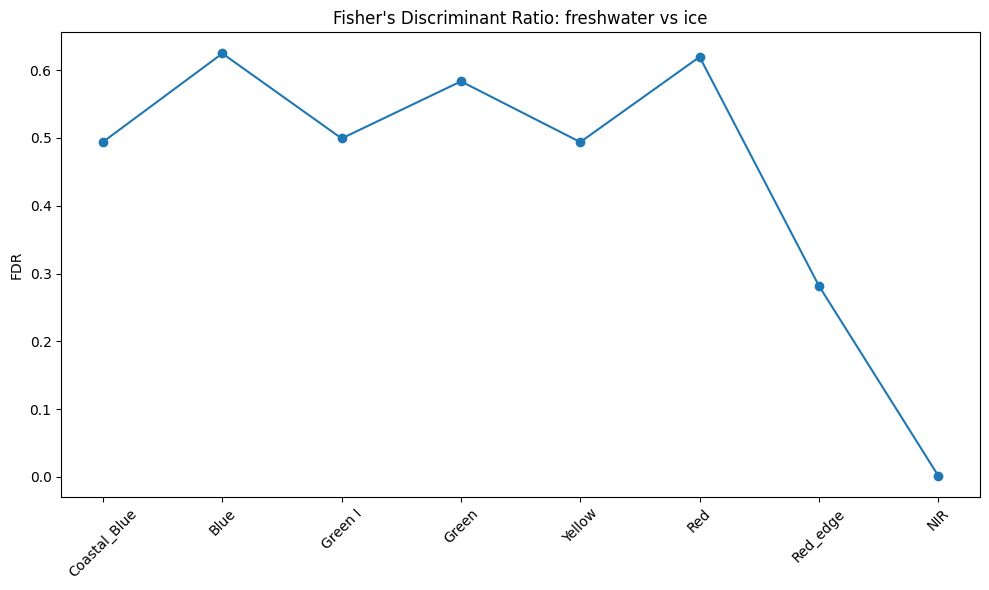

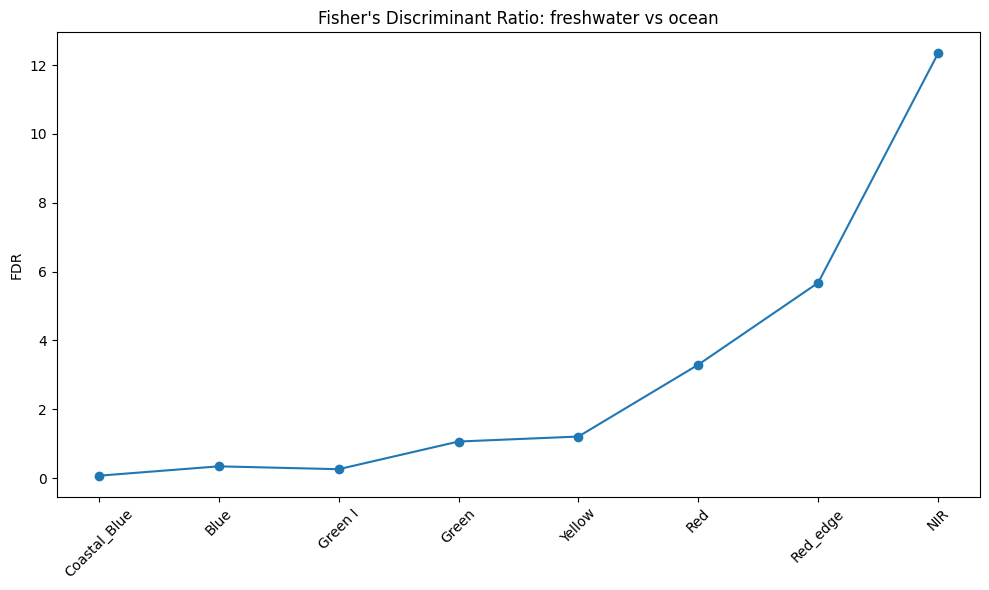

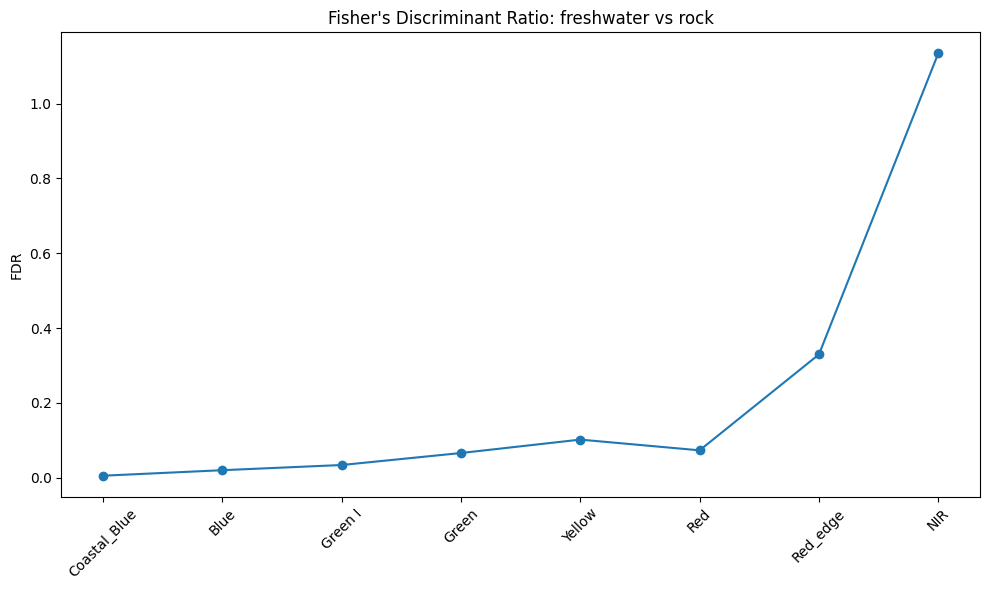

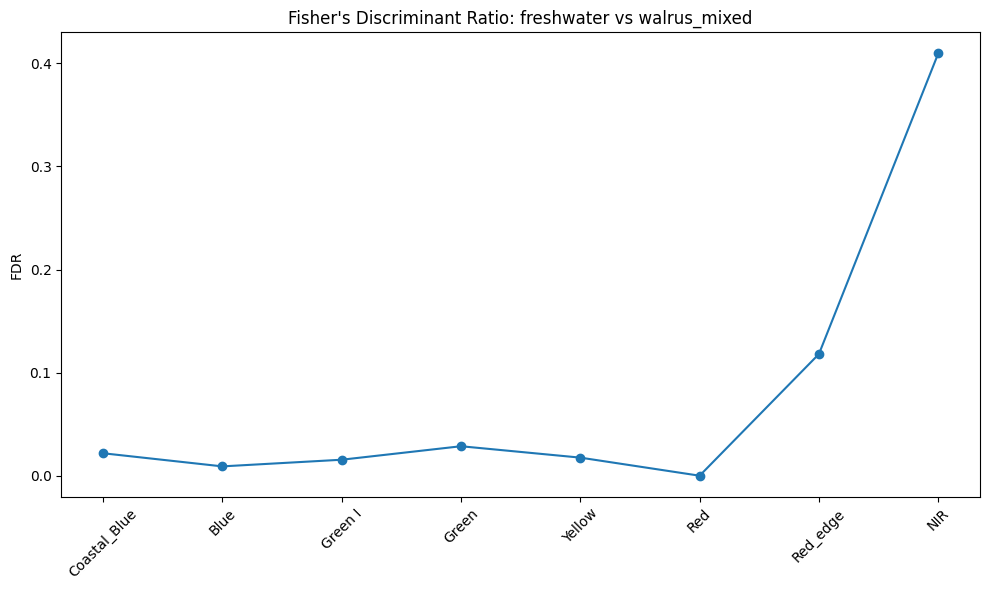

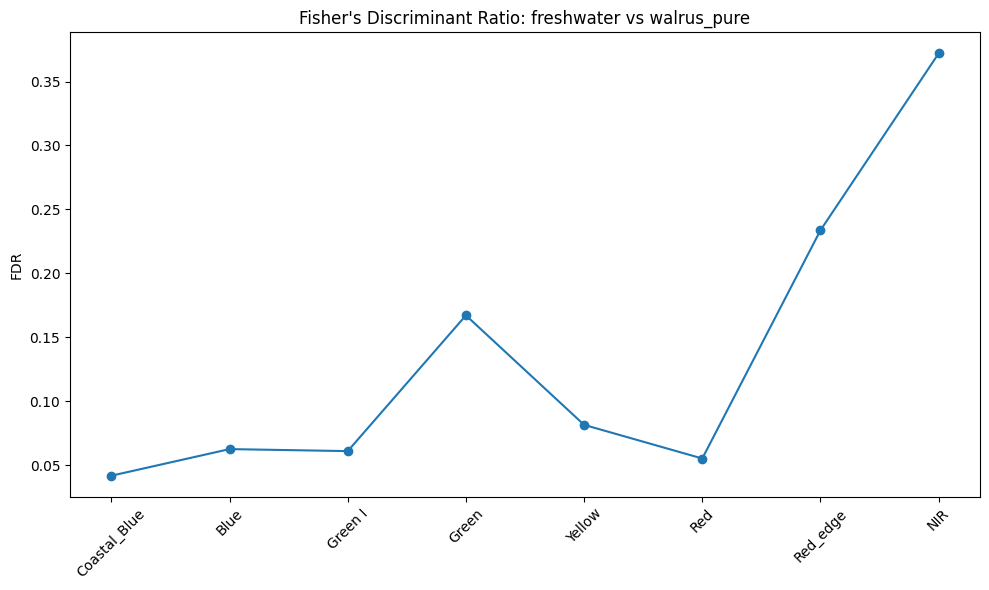

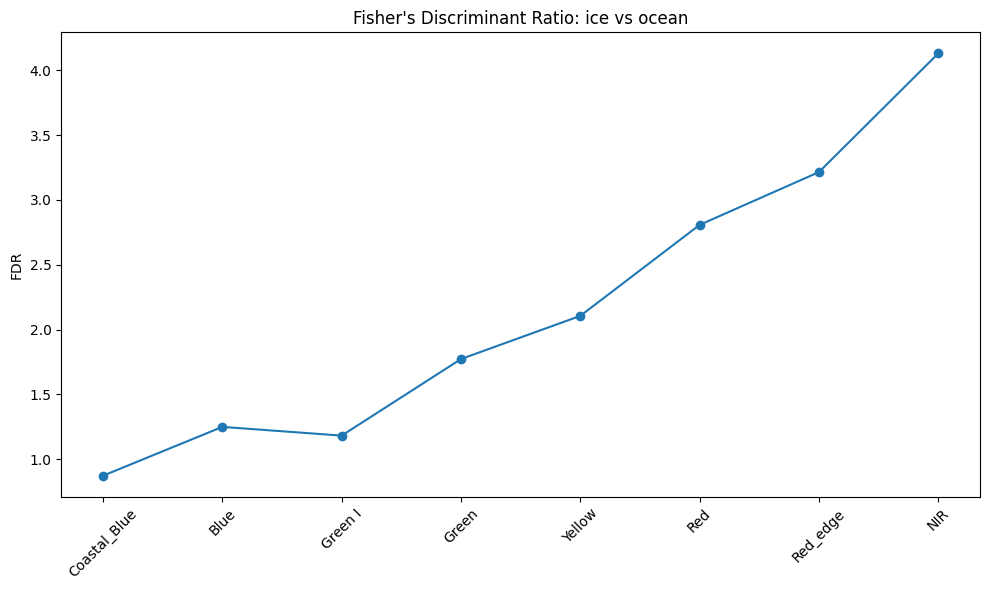

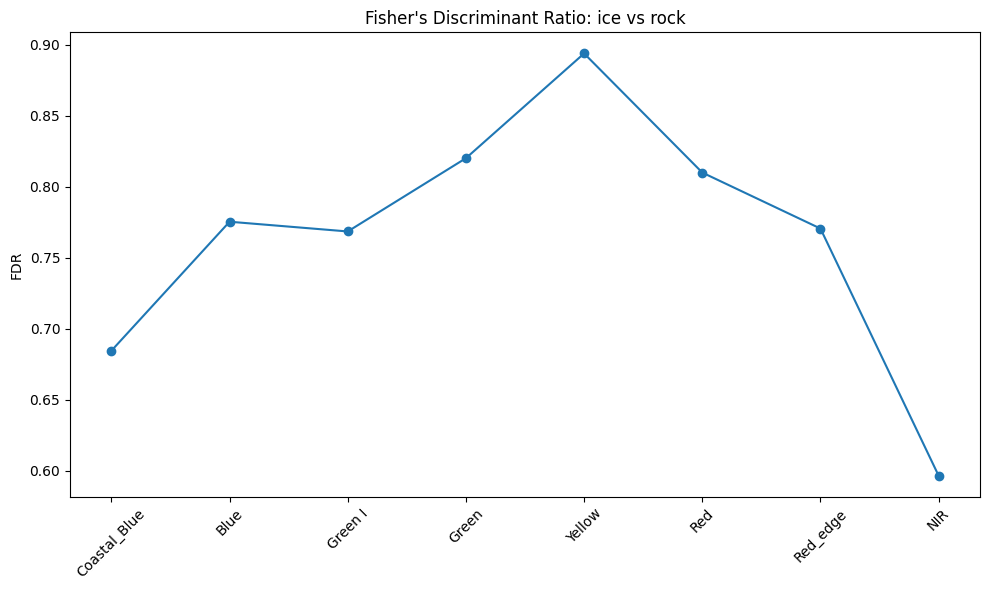

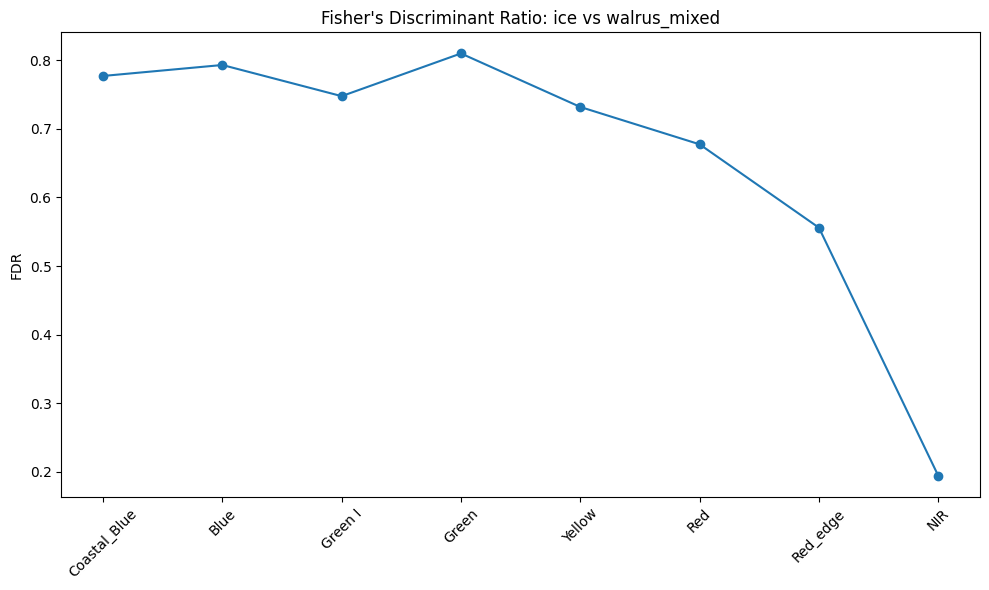

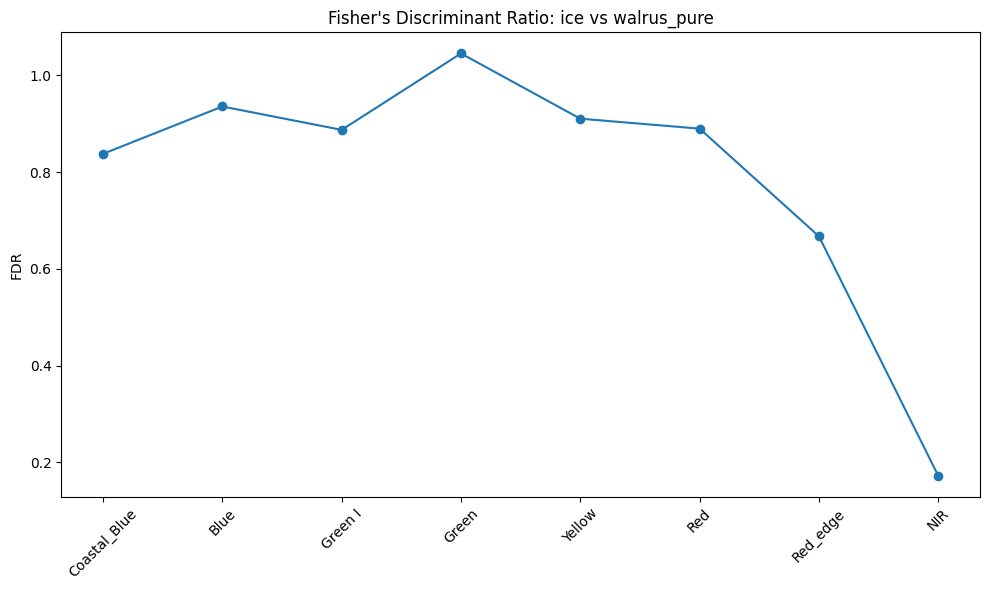

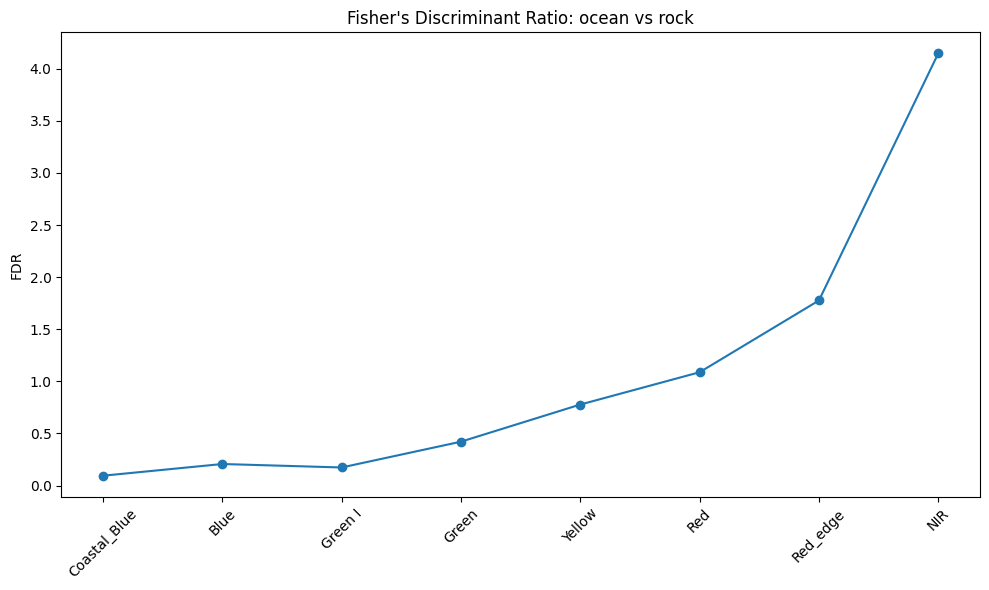

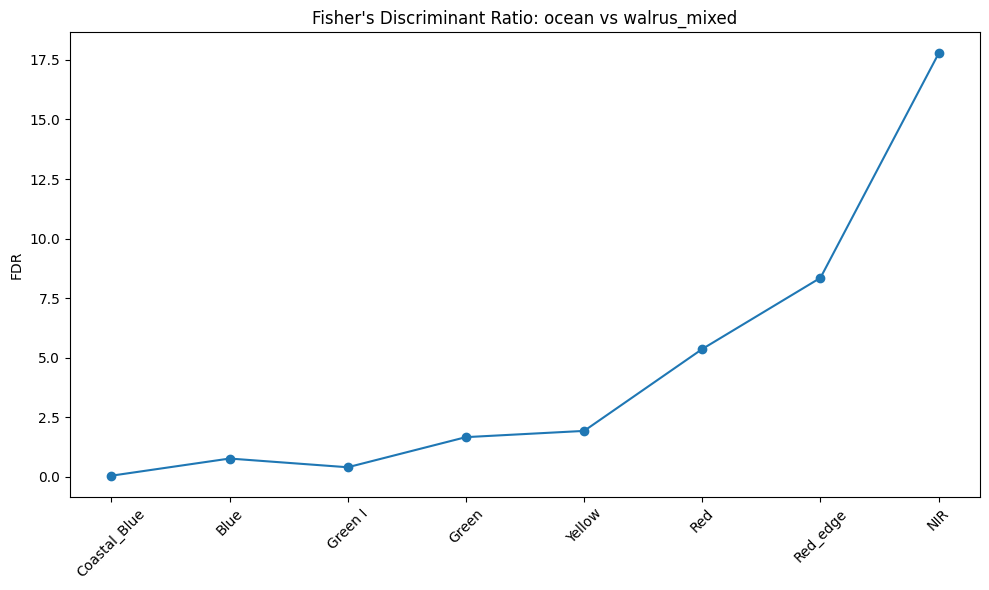

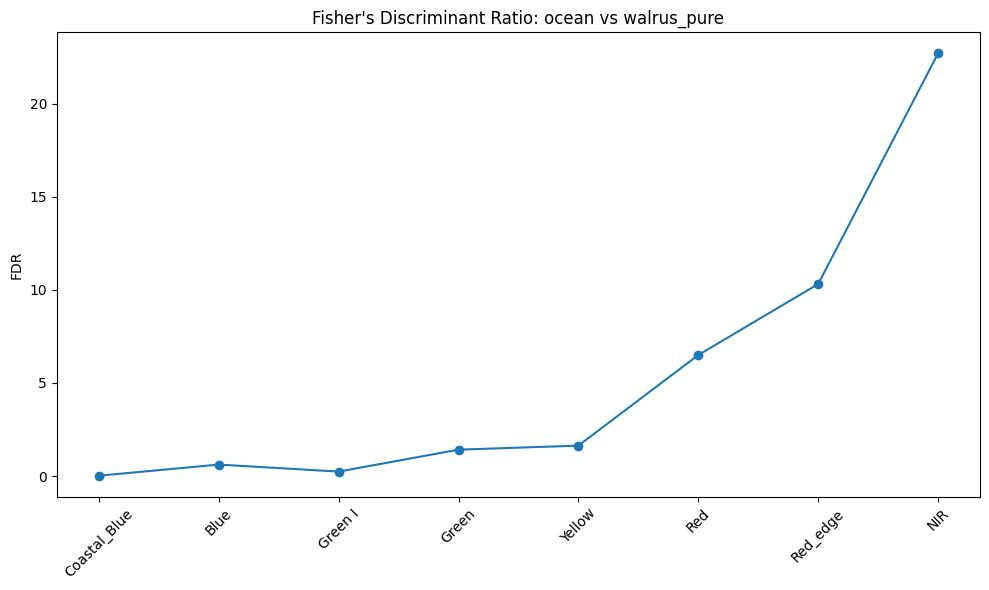

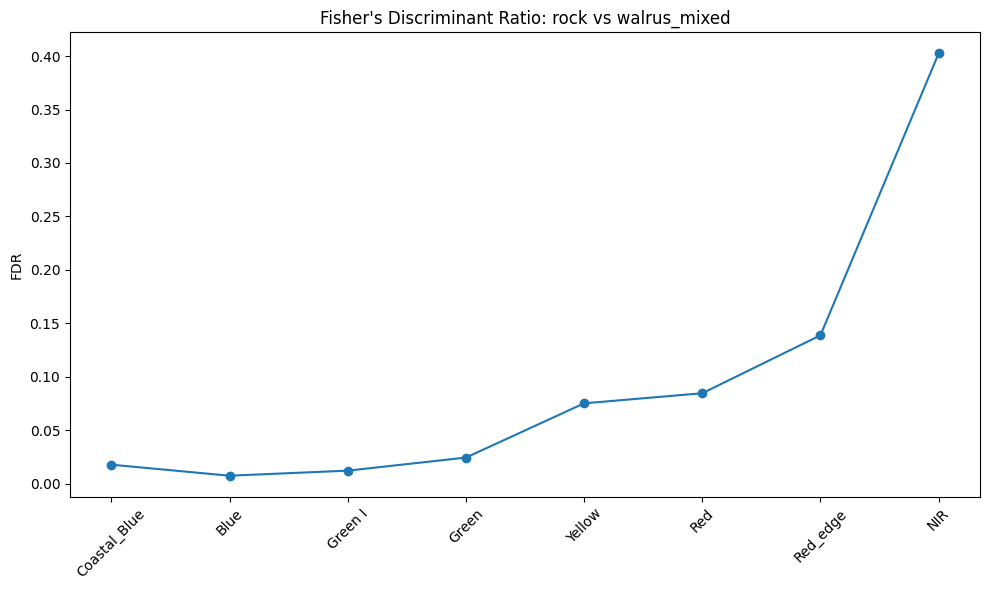

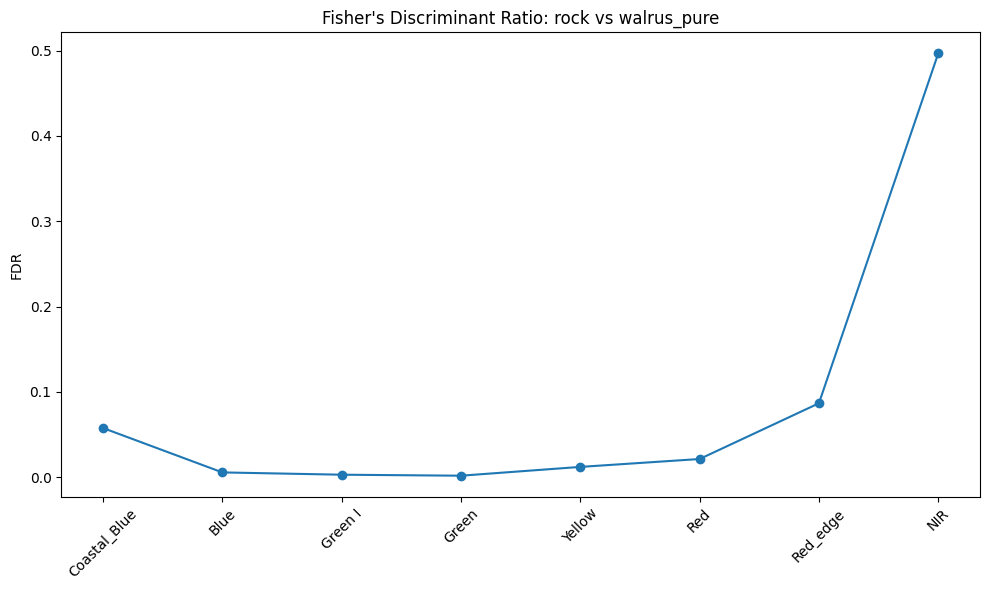

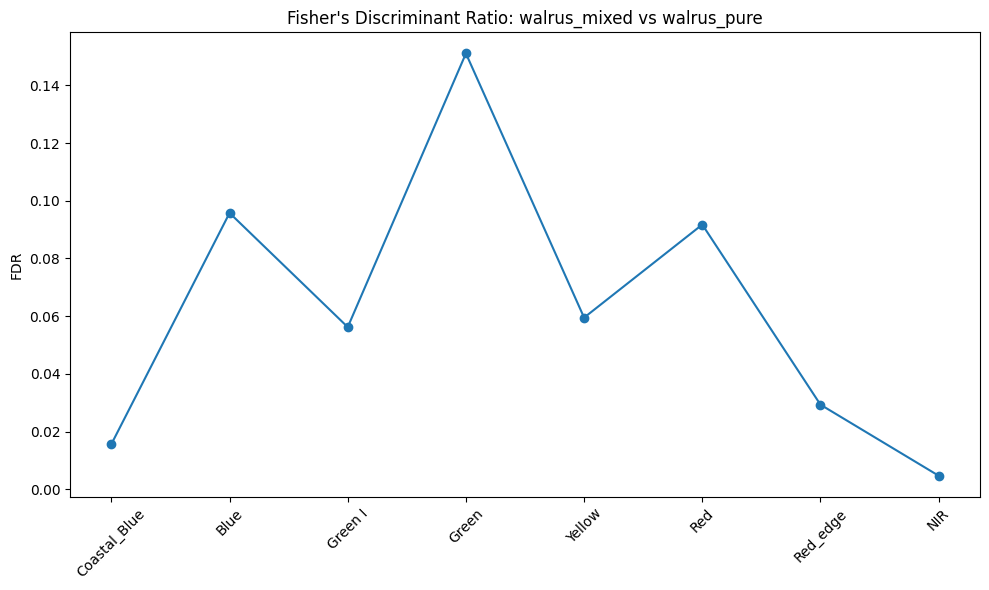

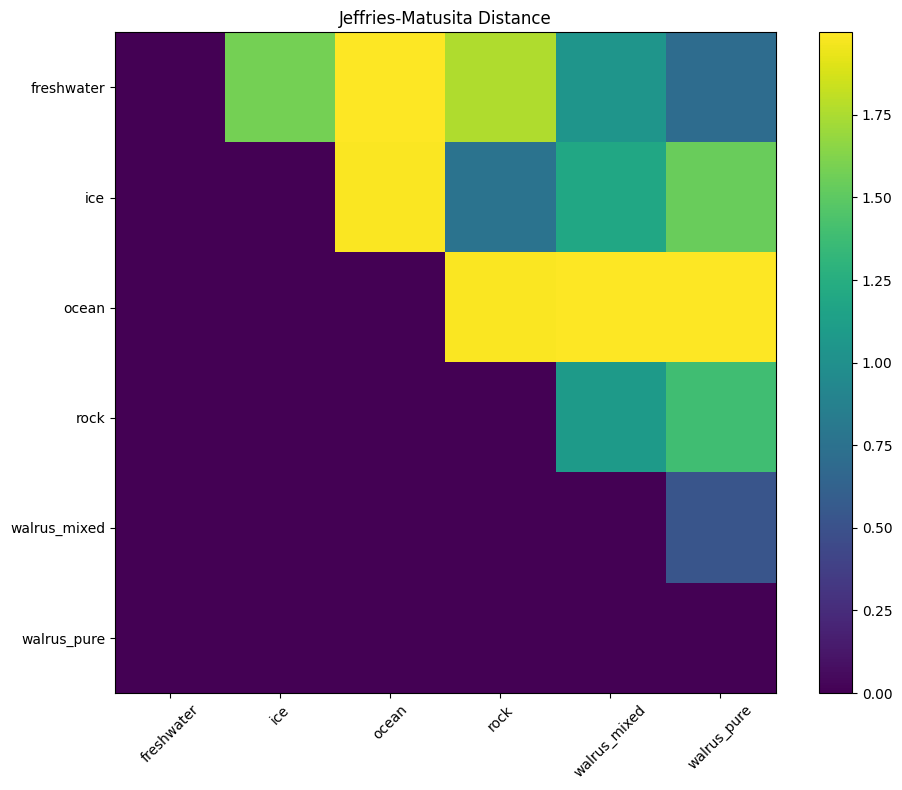

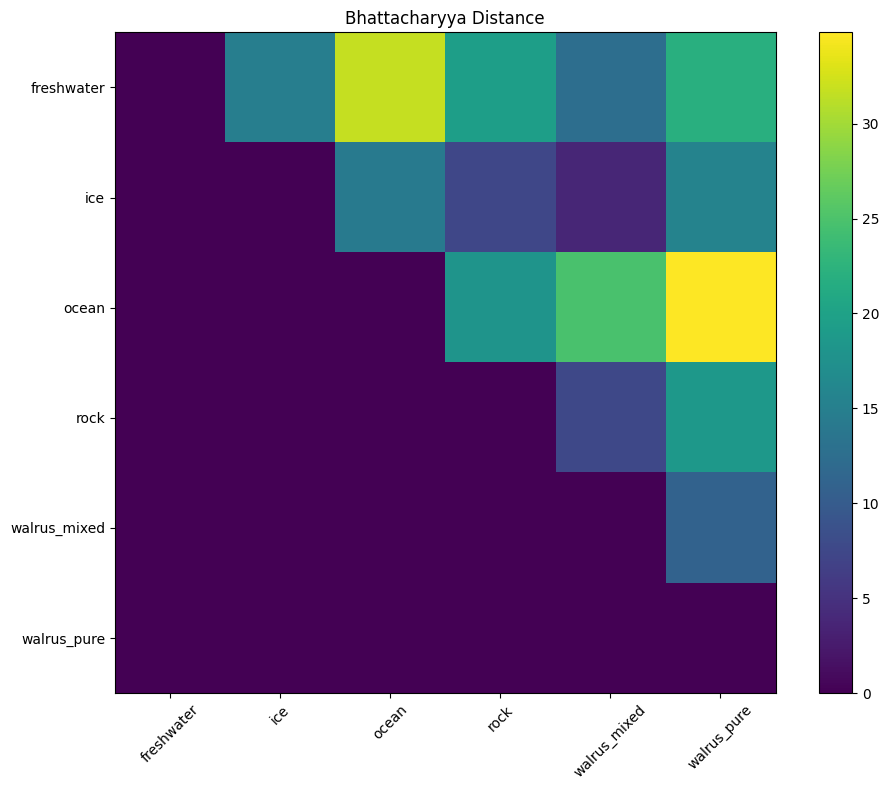

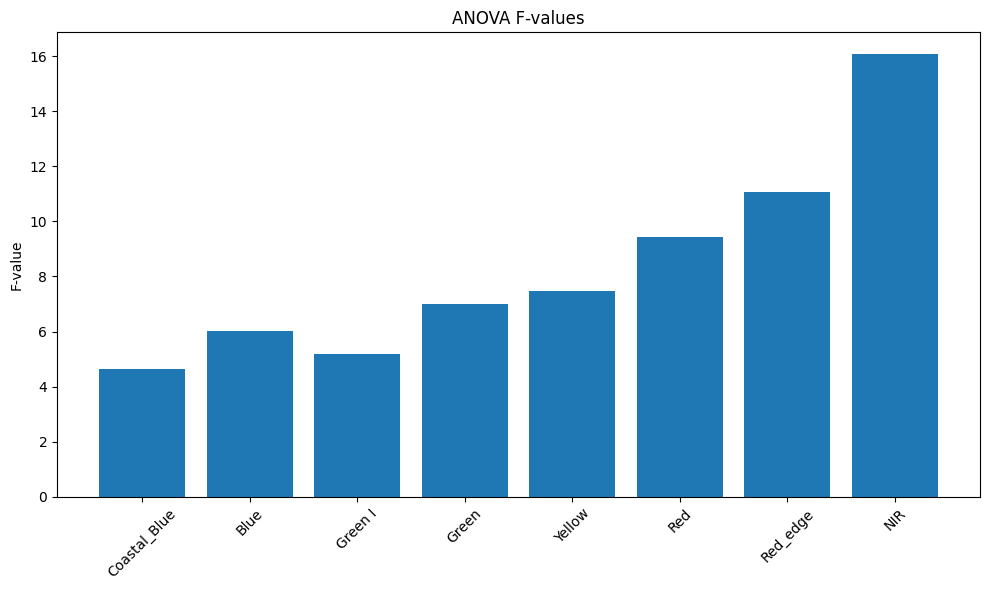

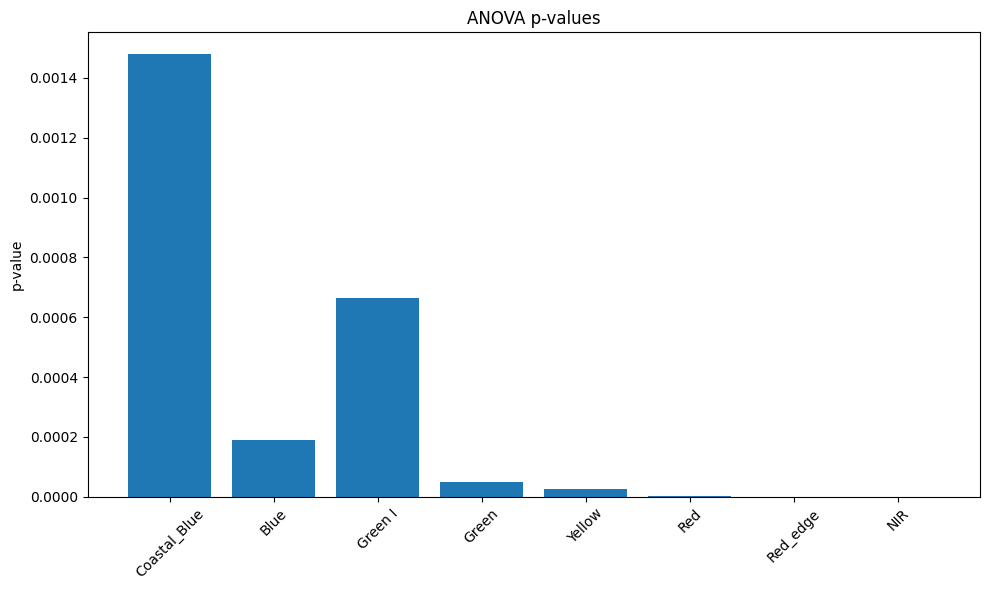

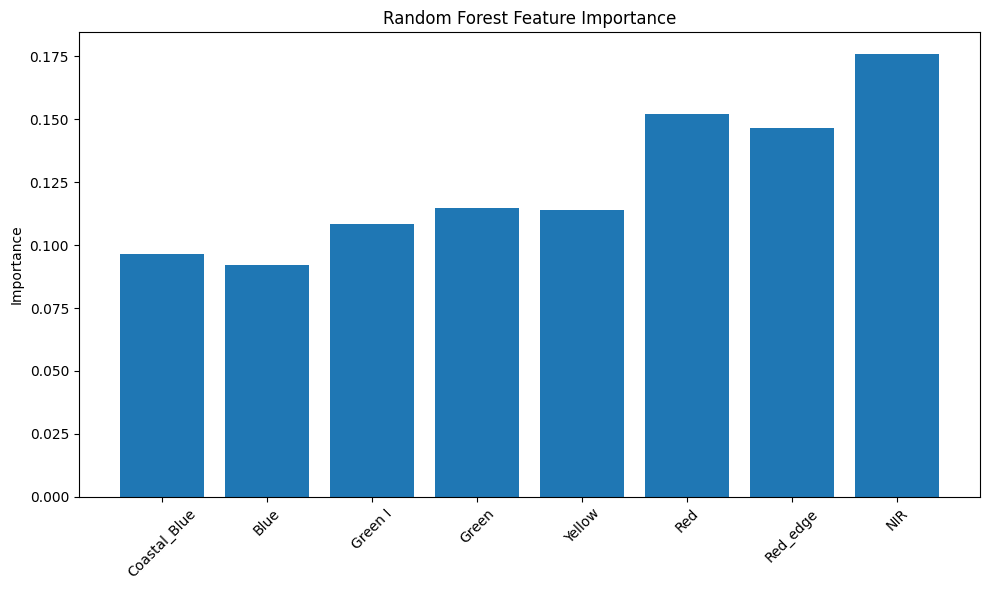

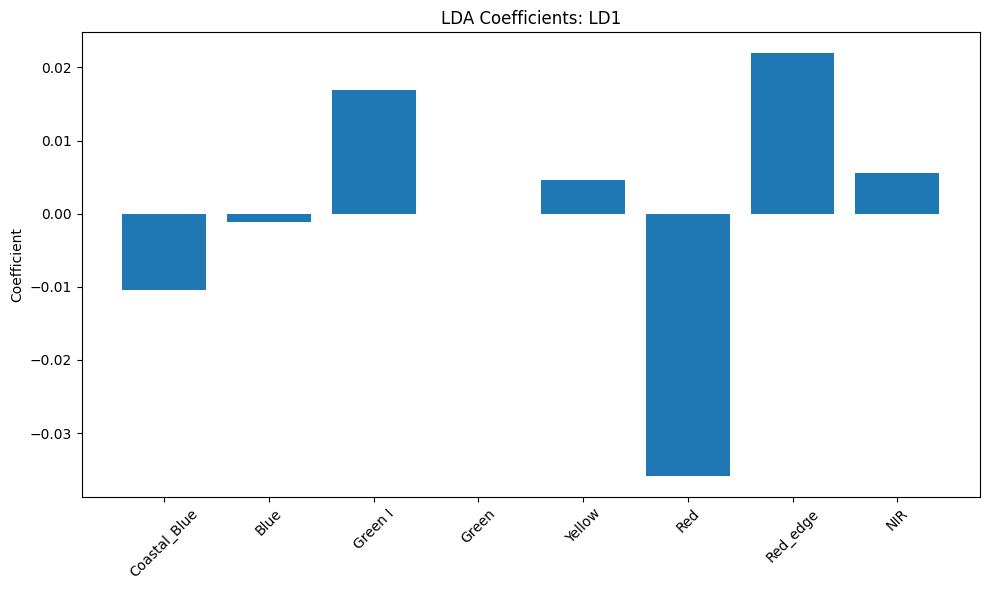

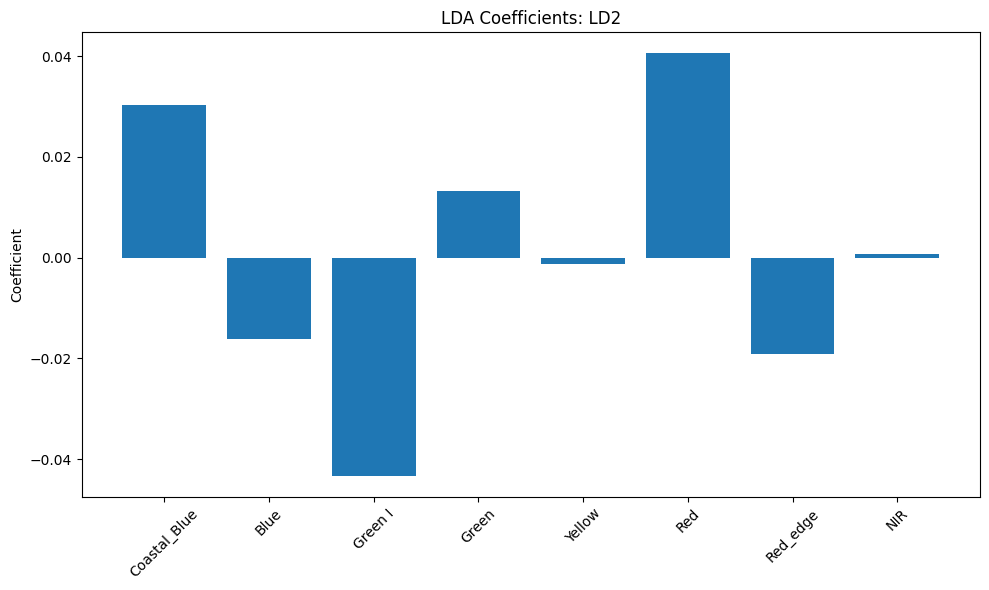

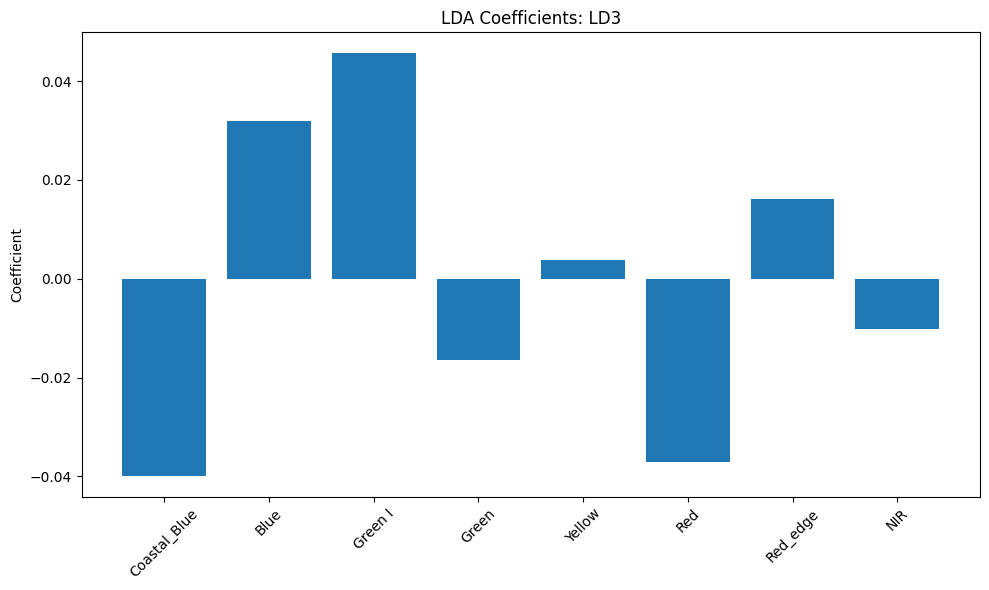

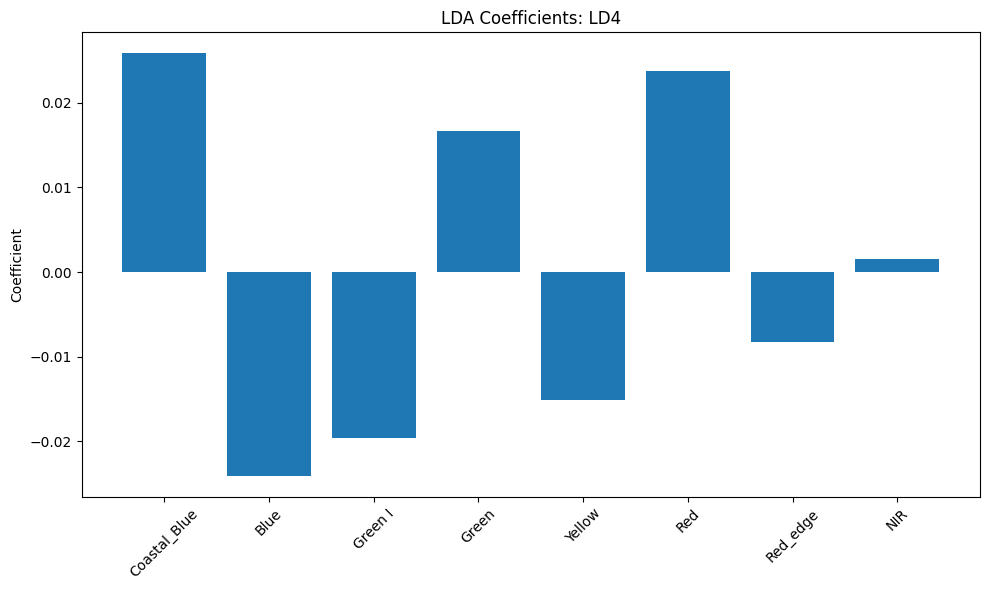

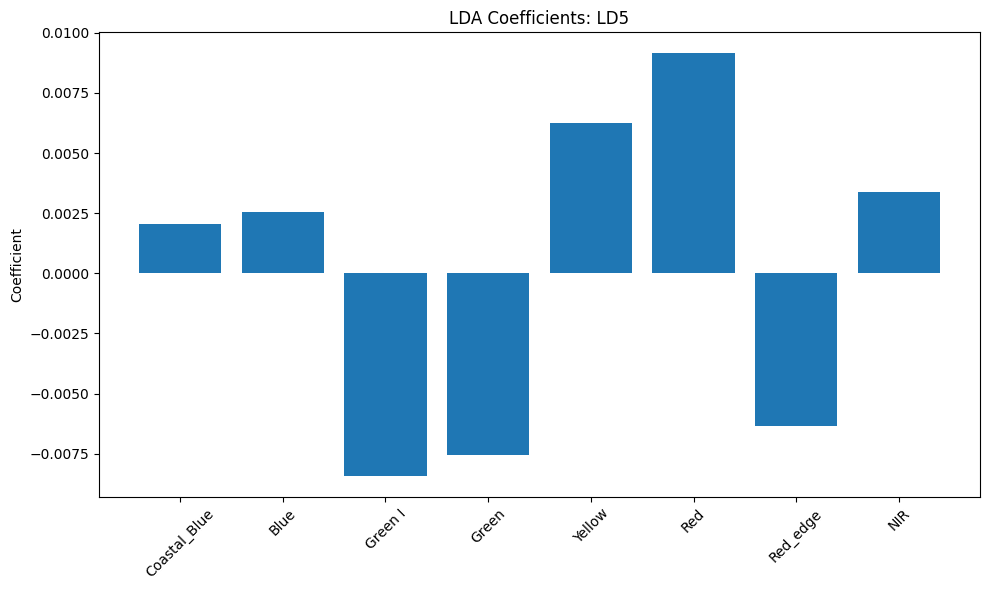

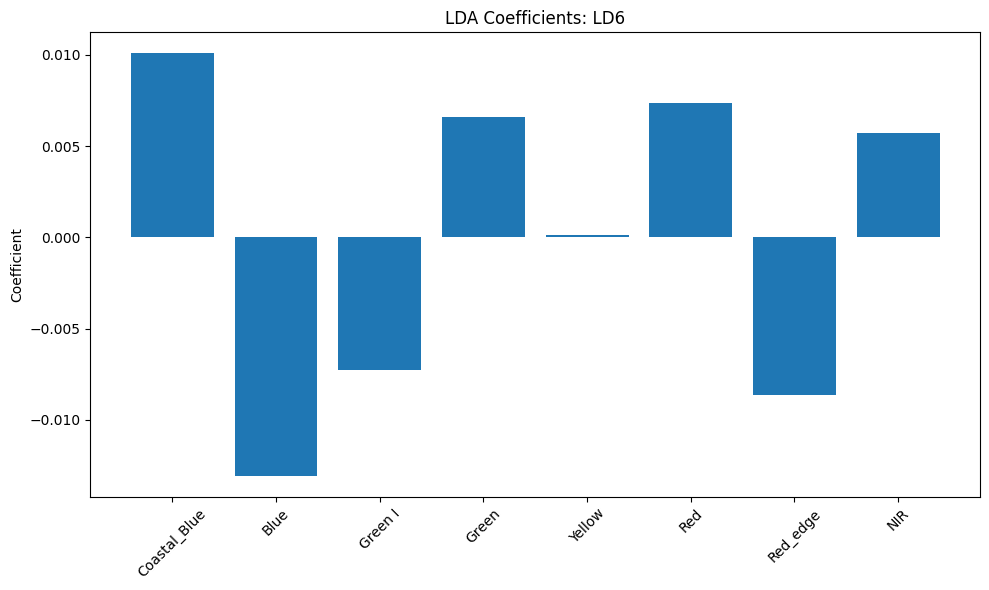

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function to plot heatmap
def plot_heatmap(matrix, title, x_labels, y_labels):
    plt.figure(figsize=(10, 8))
    plt.imshow(matrix, interpolation='nearest', cmap='viridis')
    plt.title(title)
    plt.colorbar()
    plt.xticks(np.arange(len(x_labels)), x_labels, rotation=45)
    plt.yticks(np.arange(len(y_labels)), y_labels)
    plt.tight_layout()
    plt.show()

# Helper function to plot bar chart
def plot_bar(data, title, x_labels, y_label):
    plt.figure(figsize=(10, 6))
    plt.bar(x_labels, data)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Helper function to plot line chart
def plot_line(data, title, x_labels, y_label):
    plt.figure(figsize=(10, 6))
    plt.plot(x_labels, data, marker='o')
    plt.title(title)
    plt.ylabel(y_label)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plot FDR
fdr = results['fdr']
classes = results['classes']
for i in range(len(classes)):
    for j in range(i + 1, len(classes)):
        plot_line(fdr[i, j], f"Fisher's Discriminant Ratio: {classes[i]} vs {classes[j]}", band_labels, "FDR")

# Plot JM
plot_heatmap(results['jm_distance'], "Jeffries-Matusita Distance", classes, classes)

# Plot BD
plot_heatmap(results['bhattacharyya_distance'], "Bhattacharyya Distance", classes, classes)

# Plot ANOVA F-values and p-values
plot_bar(results['anova_f'], "ANOVA F-values", band_labels, "F-value")
plot_bar(results['anova_p'], "ANOVA p-values", band_labels, "p-value")

# Plot Random Forest Feature Importance
plot_bar(results['rf_importance'], "Random Forest Feature Importance", band_labels, "Importance")

# Plot LDA Coefficients
lda_classes = [f"LD{i+1}" for i in range(results['lda_coef'].shape[0])]
for i, lda_class in enumerate(lda_classes):
    plot_bar(results['lda_coef'][i], f"LDA Coefficients: {lda_class}", band_labels, "Coefficient")


In [58]:
import os
import glob
import re
import numpy as np
import rasterio
import geopandas as gpd
from rasterio.mask import geometry_mask
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

In [66]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Pair image and shapefile paths based on filenames
def pair_files(image_paths, shapefile_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        if not matching_shapefiles:
            print(f"No matching shapefile found for {image_path}")
            continue

        shapefile_path = matching_shapefiles[0]
        file_pairs[image_path] = shapefile_path
    return file_pairs

file_pairs = pair_files(image_paths, shapefile_paths)

# Pair new walrus images with existing images
def pair_walrus_files(new_walrus_paths, image_paths):
    for walrus_path in new_walrus_paths:
        island, date = extract_island_and_date(os.path.basename(walrus_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {walrus_path}")
            continue

        matching_images = [image for image in image_paths if island in image and date in image]
        if not matching_images:
            print(f"No matching image found for {walrus_path}")
            continue

        image_path = matching_images[0]
        file_pairs[image_path] = walrus_path

pair_walrus_files(new_walrus_paths, image_paths + unlabeled_image_paths)

# Function to extract spectral signatures for a given class
def extract_spectral_signatures(image_path, shapefile_path, target_classes):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    class_pixels = {cls: [] for cls in target_classes}

    for _, row in gdf.iterrows():
        if row['label'] in target_classes:
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            class_pixels[row['label']].append(image[:, mask])

    for cls in target_classes:
        if class_pixels[cls]:
            class_pixels[cls] = np.concatenate(class_pixels[cls], axis=1)
            class_spectral_signature = np.mean(class_pixels[cls], axis=1)
            class_pixels[cls] = class_spectral_signature
        else:
            class_pixels[cls] = None

    return class_pixels

# Define target classes
target_classes = ['walrus_pure', 'walrus_mixed', 'rock', 'ice', 'ocean', 'freshwater']

No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif


No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif


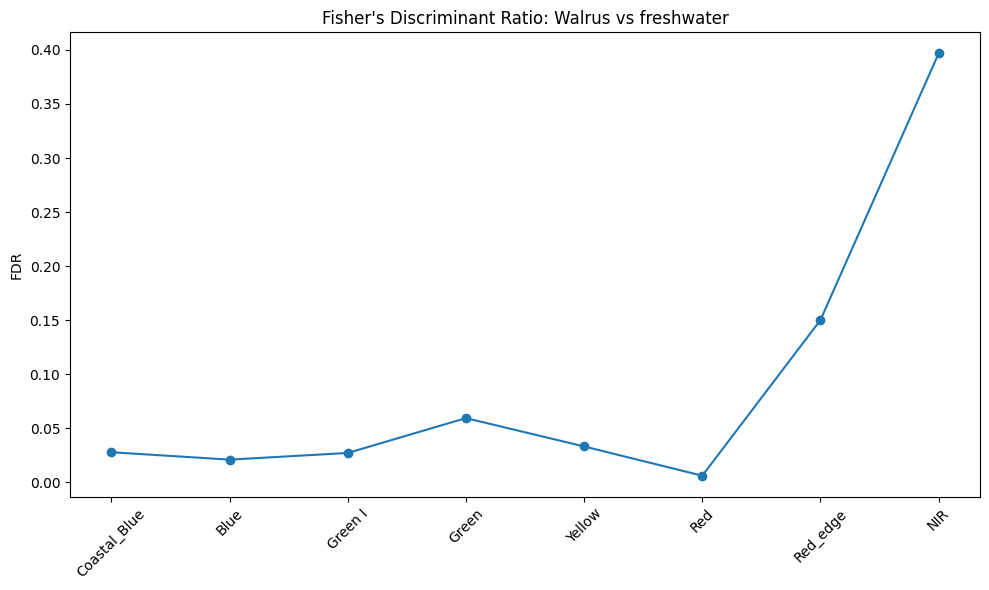

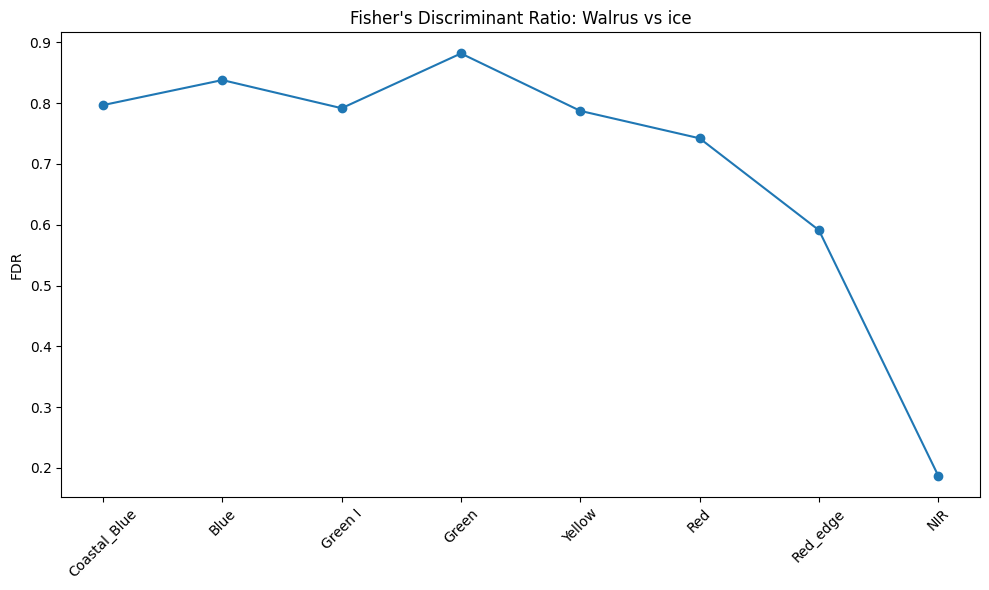

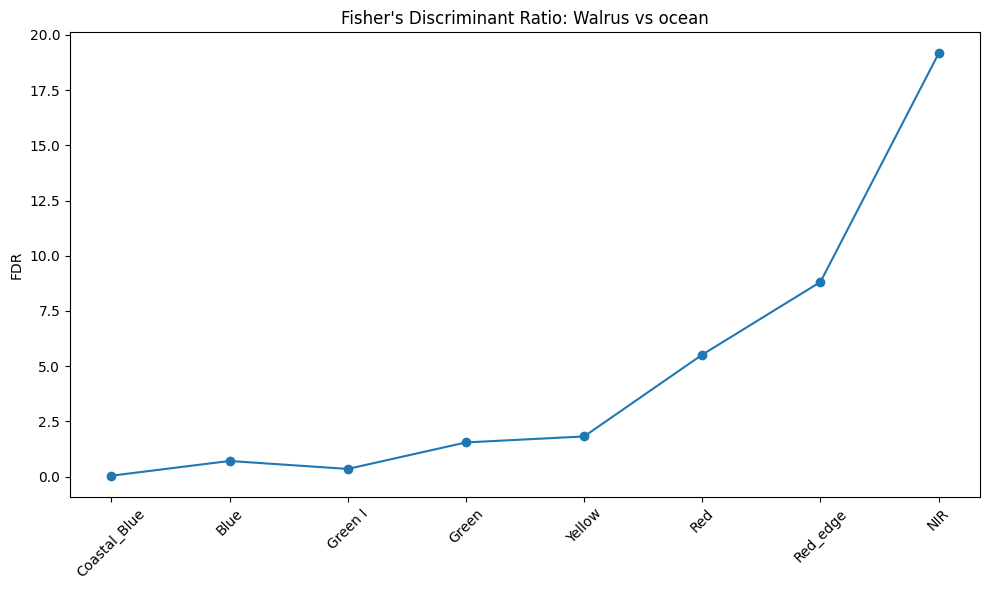

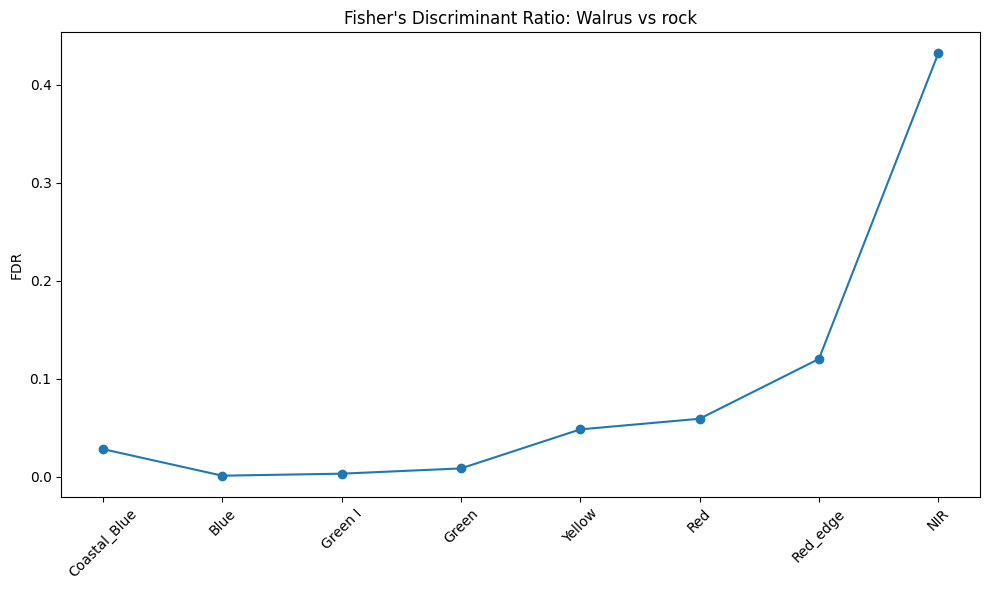

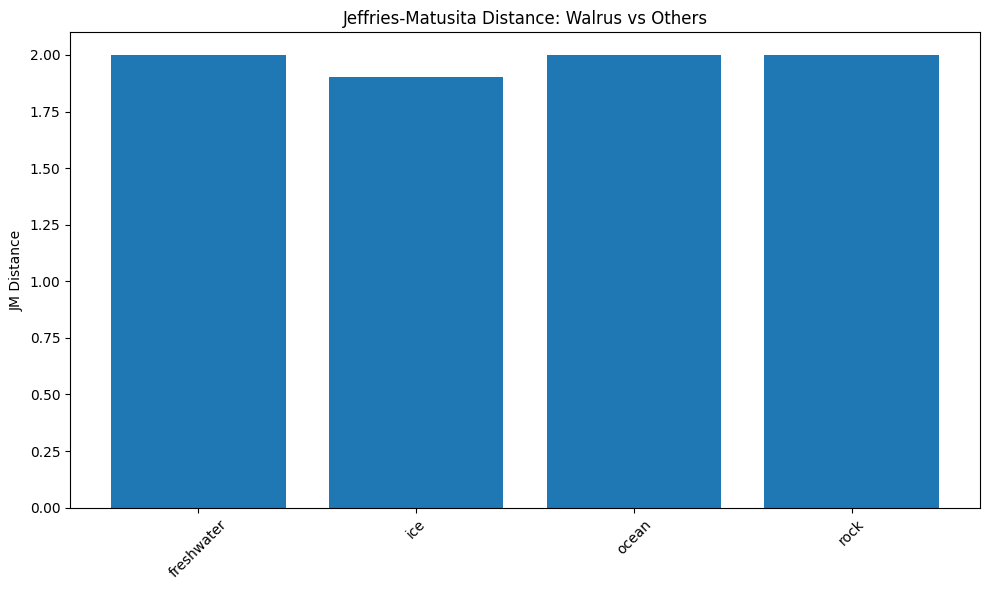

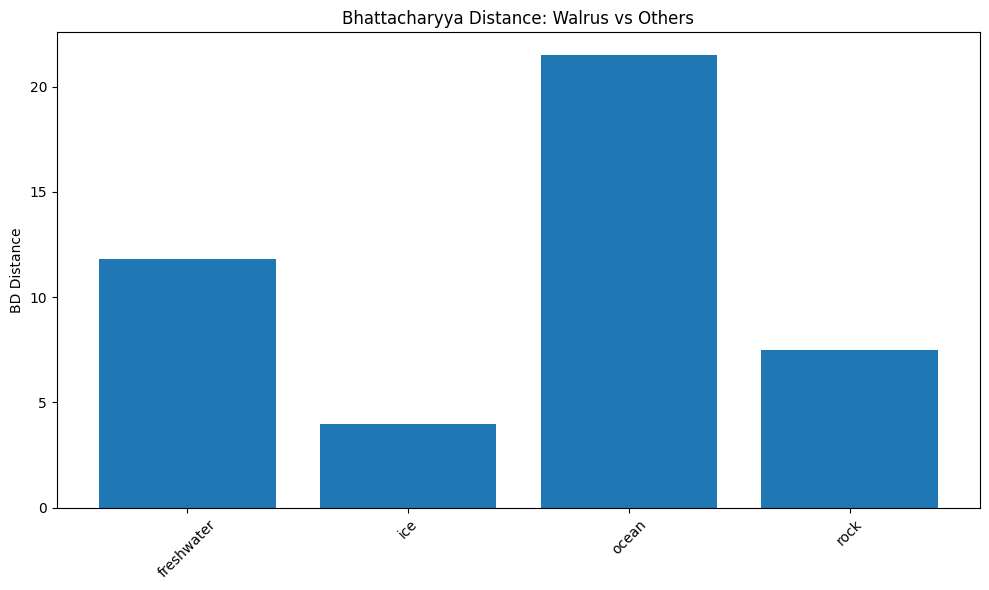

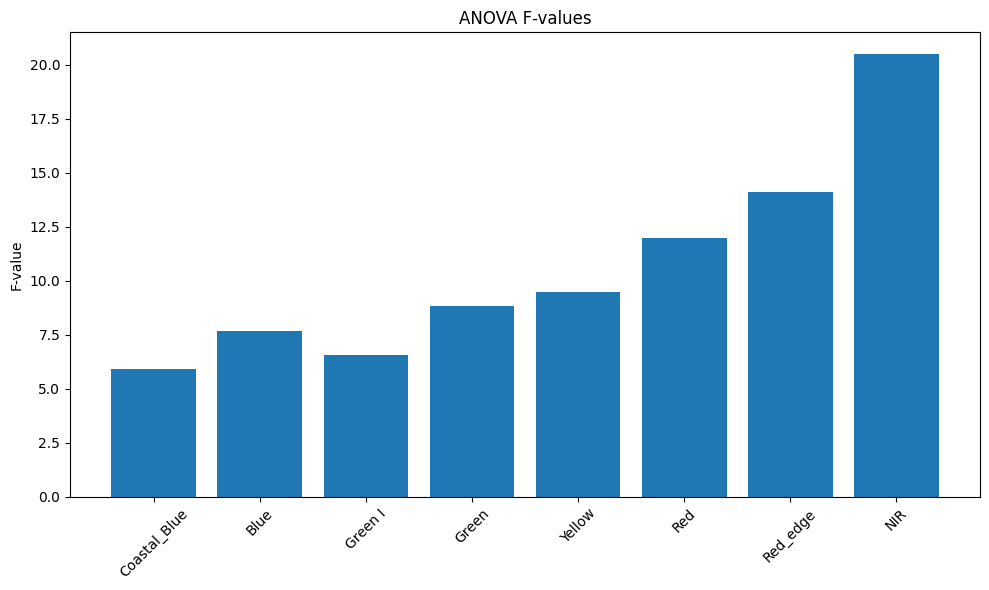

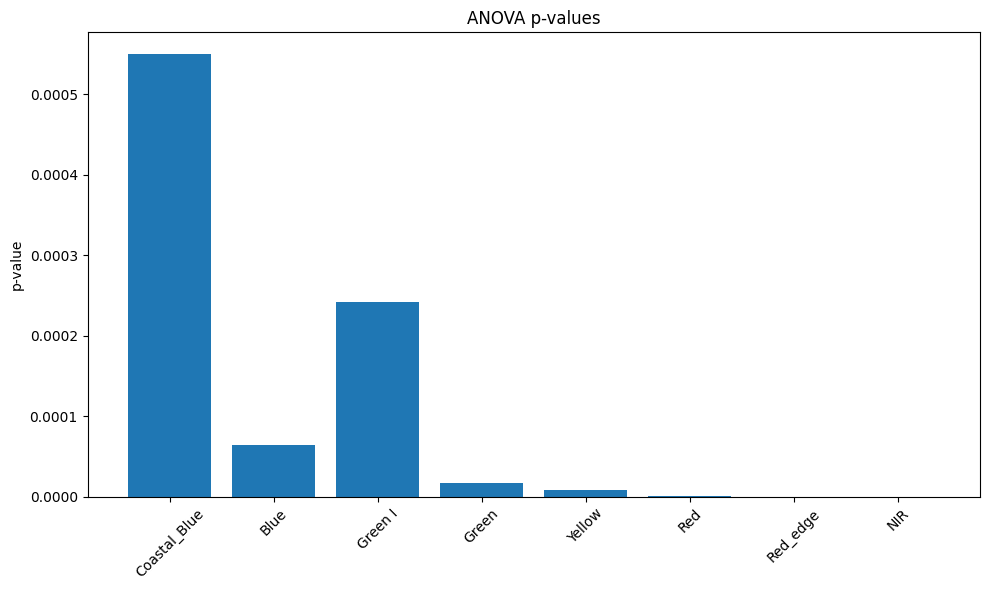

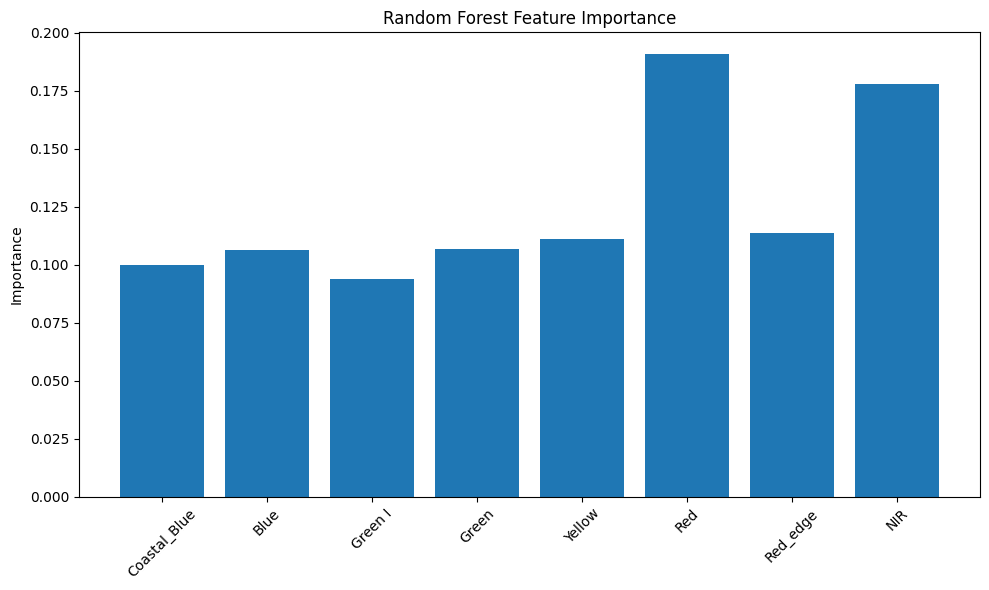

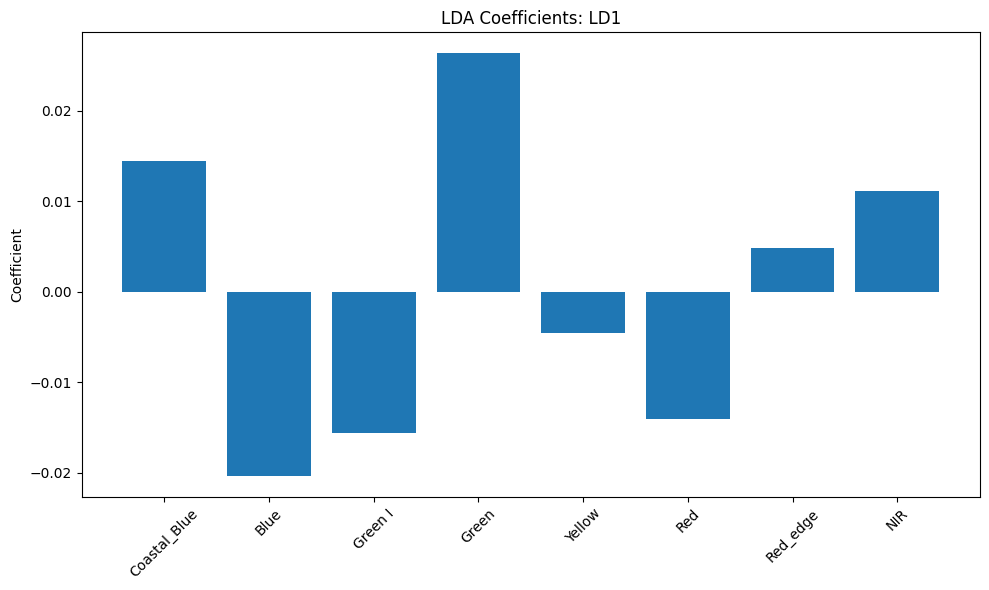

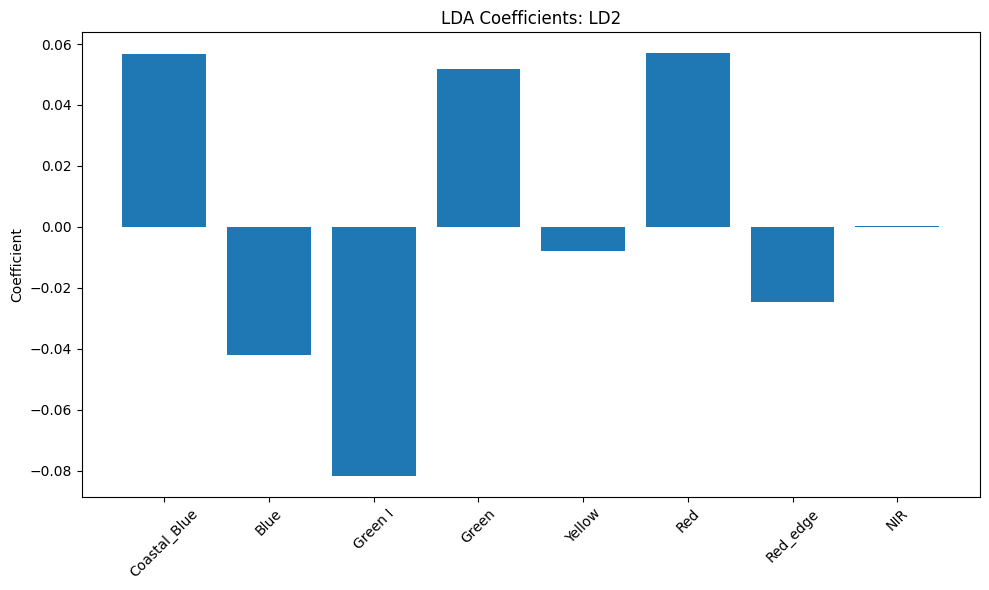

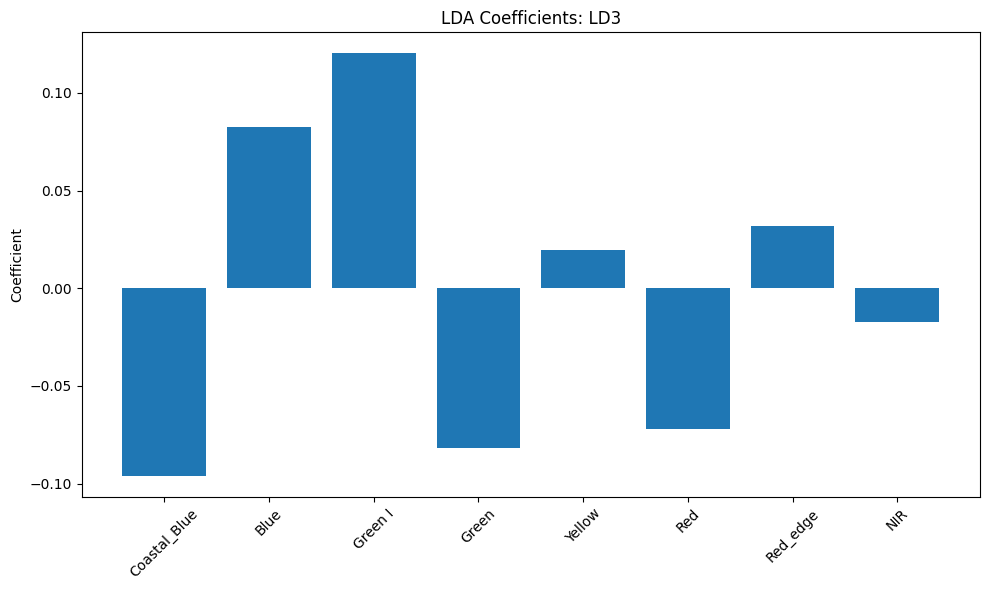

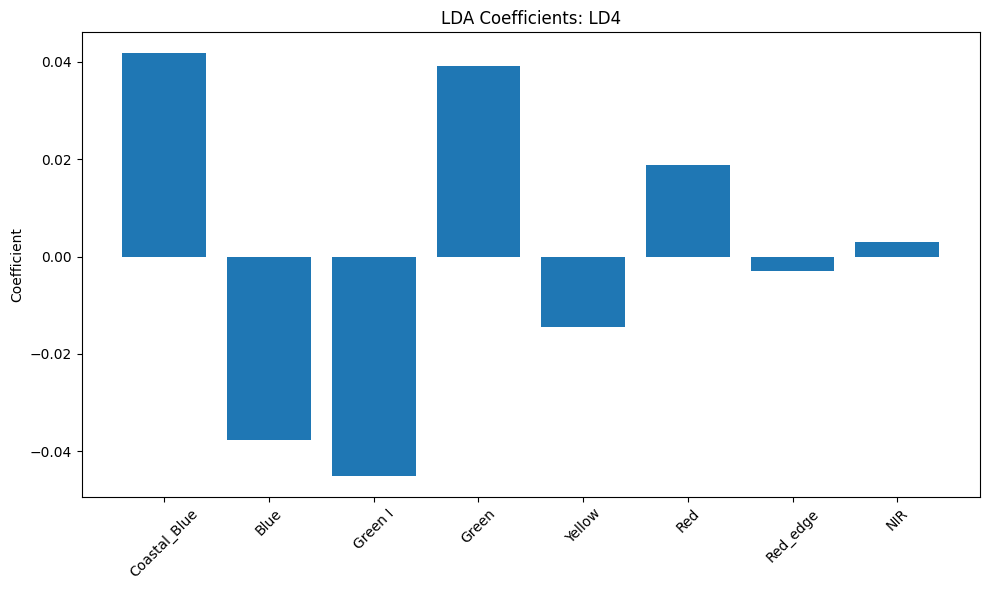

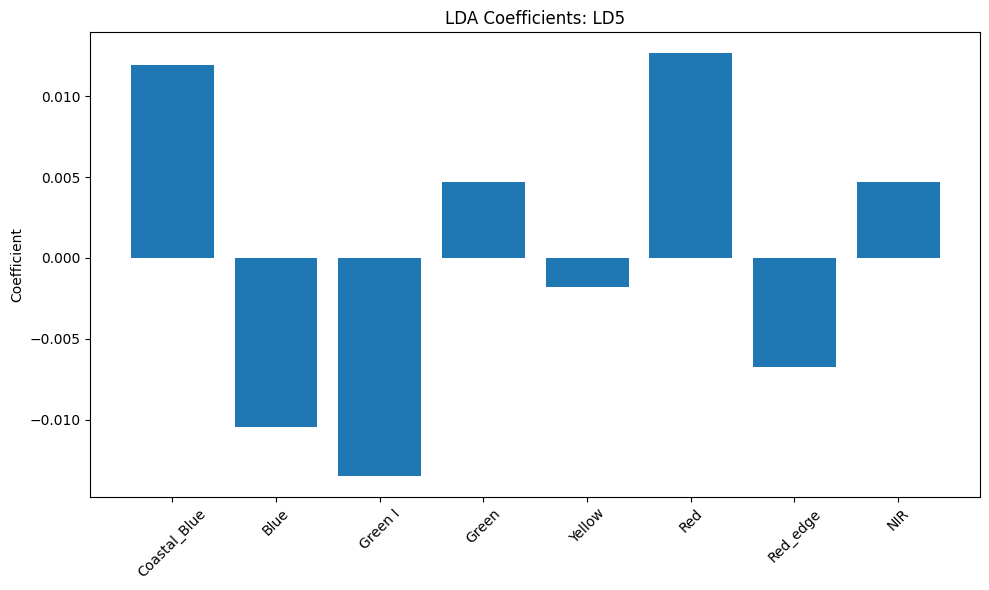

In [69]:
import os
import glob
import re
import numpy as np
import rasterio
import geopandas as gpd
from rasterio.mask import geometry_mask
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split

# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Pair image and shapefile paths based on filenames
def pair_files(image_paths, shapefile_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        if not matching_shapefiles:
            print(f"No matching shapefile found for {image_path}")
            continue

        shapefile_path = matching_shapefiles[0]
        file_pairs[image_path] = shapefile_path
    return file_pairs

file_pairs = pair_files(image_paths, shapefile_paths)

# Pair new walrus images with existing images
def pair_walrus_files(new_walrus_paths, image_paths):
    for walrus_path in new_walrus_paths:
        island, date = extract_island_and_date(os.path.basename(walrus_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {walrus_path}")
            continue

        matching_images = [image for image in image_paths if island in image and date in image]
        if not matching_images:
            print(f"No matching image found for {walrus_path}")
            continue

        image_path = matching_images[0]
        file_pairs[image_path] = walrus_path

pair_walrus_files(new_walrus_paths, image_paths + unlabeled_image_paths)

# Function to extract spectral signatures for a given class
def extract_spectral_signatures(image_path, shapefile_path, target_classes):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    class_pixels = {cls: [] for cls in target_classes}

    for _, row in gdf.iterrows():
        if row['label'] in target_classes:
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            class_pixels[row['label']].append(image[:, mask])

    for cls in target_classes:
        if class_pixels[cls]:
            class_pixels[cls] = np.concatenate(class_pixels[cls], axis=1)
            class_spectral_signature = np.mean(class_pixels[cls], axis=1)
            class_pixels[cls] = class_spectral_signature
        else:
            class_pixels[cls] = None

    return class_pixels

# Define target classes
target_classes = ['walrus_pure', 'walrus_mixed', 'rock', 'ice', 'ocean', 'freshwater']

# Extract and store spectral signatures for all classes
all_spectral_signatures = {cls: [] for cls in target_classes}

for image_path, shapefile_path in file_pairs.items():
    signatures = extract_spectral_signatures(image_path, shapefile_path, target_classes)
    for cls, signature in signatures.items():
        if signature is not None:
            all_spectral_signatures[cls].append(signature)

# Combine walrus_pure and walrus_mixed into one class in all_spectral_signatures
walrus_signatures = []
if 'walrus_pure' in all_spectral_signatures:
    walrus_signatures.extend(all_spectral_signatures.pop('walrus_pure'))
if 'walrus_mixed' in all_spectral_signatures:
    walrus_signatures.extend(all_spectral_signatures.pop('walrus_mixed'))

if walrus_signatures:
    all_spectral_signatures['walrus'] = walrus_signatures

# Calculate mean spectral signature and standard deviation for each class
mean_spectral_signatures = {}
std_spectral_signatures = {}
for cls, signatures in all_spectral_signatures.items():
    if signatures:
        mean_spectral_signatures[cls] = np.mean(signatures, axis=0)
        std_spectral_signatures[cls] = np.std(signatures, axis=0)

# Prepare the data and labels for the comparison function
classes = list(mean_spectral_signatures.keys())
data = np.vstack([all_spectral_signatures[cls] for cls in classes if len(all_spectral_signatures[cls]) > 0])
labels = np.array(sum([[cls] * len(all_spectral_signatures[cls]) for cls in classes if len(all_spectral_signatures[cls]) > 0], []))

# Function to calculate Jeffries-Matusita Distance with regularization
def jeffries_matusita_distance(mean1, cov1, mean2, cov2, epsilon=1e-6):
    cov1 += epsilon * np.eye(cov1.shape[0])
    cov2 += epsilon * np.eye(cov2.shape[0])
    diff = mean1 - mean2
    cov_mean = (cov1 + cov2) / 2
    term1 = 0.125 * np.dot(np.dot(diff.T, np.linalg.inv(cov_mean)), diff)
    term2 = 0.5 * np.log(np.linalg.det(cov_mean) / np.sqrt(np.linalg.det(cov1) * np.linalg.det(cov2)))
    return 2 * (1 - np.exp(-term1 - term2))

# Function to calculate Bhattacharyya Distance with regularization
def bhattacharyya_distance(mean1, cov1, mean2, cov2, epsilon=1e-6):
    cov1 += epsilon * np.eye(cov1.shape[0])
    cov2 += epsilon * np.eye(cov2.shape[0])
    diff = mean1 - mean2
    cov_mean = (cov1 + cov2) / 2
    term1 = 0.25 * np.dot(np.dot(diff.T, np.linalg.inv(cov_mean)), diff)
    term2 = 0.5 * np.log(np.linalg.det(cov_mean) / np.sqrt(np.linalg.det(cov1) * np.linalg.det(cov2)))
    return term1 + term2

# Function to compare spectral signatures
def compare_spectral_signatures(data, labels, target_class):
    classes = np.unique(labels)
    n_features = data.shape[1]
    
    walrus_data = data[labels == target_class]
    walrus_mean = np.mean(walrus_data, axis=0)
    walrus_cov = np.cov(walrus_data, rowvar=False)
    
    results = {
        'fdr': {},
        'jm_distance': {},
        'bhattacharyya_distance': {},
        'anova_f': None,
        'anova_p': None,
        'rf_importance': None,
        'lda_coef': None,
        'classes': [cls for cls in classes if cls != target_class]
    }
    
    for cls in classes:
        if cls == target_class:
            continue
        
        class_data = data[labels == cls]
        class_mean = np.mean(class_data, axis=0)
        class_cov = np.cov(class_data, rowvar=False)
        
        # Fisher's Discriminant Ratio
        fdr = (walrus_mean - class_mean)**2 / (np.var(walrus_data, axis=0) + np.var(class_data, axis=0))
        results['fdr'][cls] = fdr
        
        # Jeffries-Matusita Distance
        jm_distance = jeffries_matusita_distance(walrus_mean, walrus_cov, class_mean, class_cov)
        results['jm_distance'][cls] = jm_distance
        
        # Bhattacharyya Distance
        bd_distance = bhattacharyya_distance(walrus_mean, walrus_cov, class_mean, class_cov)
        results['bhattacharyya_distance'][cls] = bd_distance

    # ANOVA
    f_values, p_values = stats.f_oneway(*[data[labels == cls] for cls in classes])
    results['anova_f'] = f_values
    results['anova_p'] = p_values
    
    # Random Forest Feature Importance
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42)
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    results['rf_importance'] = rf.feature_importances_
    
    # Linear Discriminant Analysis
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    results['lda_coef'] = lda.coef_
    
    return results

# Helper function to plot bar chart
def plot_bar(data, title, x_labels, y_label):
    plt.figure(figsize=(10, 6))
    plt.bar(x_labels, data)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Helper function to plot line chart
def plot_line(data, title, x_labels, y_label):
    plt.figure(figsize=(10, 6))
    plt.plot(x_labels, data, marker='o')
    plt.title(title)
    plt.ylabel(y_label)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Filter to keep only walrus and other relevant classes
relevant_classes = ['walrus', 'rock', 'ice', 'ocean', 'freshwater']
data_filtered = data[np.isin(labels, relevant_classes)]
labels_filtered = labels[np.isin(labels, relevant_classes)]

# Run the comparison
results = compare_spectral_signatures(data_filtered, labels_filtered, target_class='walrus')

# Plot the results
# Plot FDR
for cls in results['classes']:
    plot_line(results['fdr'][cls], f"Fisher's Discriminant Ratio: Walrus vs {cls}", band_labels, "FDR")

# Plot JM Distance
plot_bar([results['jm_distance'][cls] for cls in results['classes']], "Jeffries-Matusita Distance: Walrus vs Others", results['classes'], "JM Distance")

# Plot Bhattacharyya Distance
plot_bar([results['bhattacharyya_distance'][cls] for cls in results['classes']], "Bhattacharyya Distance: Walrus vs Others", results['classes'], "BD Distance")

# Plot ANOVA F-values and p-values
plot_bar(results['anova_f'], "ANOVA F-values", band_labels, "F-value")
plot_bar(results['anova_p'], "ANOVA p-values", band_labels, "p-value")

# Plot Random Forest Feature Importance
plot_bar(results['rf_importance'], "Random Forest Feature Importance", band_labels, "Importance")

# Plot LDA Coefficients
lda_classes = [f"LD{i+1}" for i in range(results['lda_coef'].shape[0])]
for i, lda_class in enumerate(lda_classes):
    plot_bar(results['lda_coef'][i], f"LDA Coefficients: {lda_class}", band_labels, "Coefficient")


In [70]:
# Print the results
print("Fisher's Discriminant Ratio (FDR):")
for cls in results['classes']:
    print(f"Walrus vs {cls}:")
    for band, fdr_value in zip(band_labels, results['fdr'][cls]):
        print(f"  {band}: {fdr_value:.4f}")
    print()

print("Jeffries-Matusita Distance (JM):")
for cls in results['classes']:
    print(f"Walrus vs {cls}: {results['jm_distance'][cls]:.4f}")

print("\nBhattacharyya Distance (BD):")
for cls in results['classes']:
    print(f"Walrus vs {cls}: {results['bhattacharyya_distance'][cls]:.4f}")

print("\nANOVA F-values:")
for band, f_value in zip(band_labels, results['anova_f']):
    print(f"  {band}: {f_value:.4f}")

print("\nANOVA p-values:")
for band, p_value in zip(band_labels, results['anova_p']):
    print(f"  {band}: {p_value:.4e}")

print("\nRandom Forest Feature Importance:")
for band, importance in zip(band_labels, results['rf_importance']):
    print(f"  {band}: {importance:.4f}")

print("\nLDA Coefficients:")
for i, lda_class in enumerate(lda_classes):
    print(f"{lda_class}:")
    for band, coef in zip(band_labels, results['lda_coef'][i]):
        print(f"  {band}: {coef:.4f}")
    print()


Fisher's Discriminant Ratio (FDR):
Walrus vs freshwater:
  Coastal_Blue: 0.0278
  Blue: 0.0209
  Green I: 0.0271
  Green: 0.0593
  Yellow: 0.0331
  Red: 0.0060
  Red_edge: 0.1501
  NIR: 0.3967

Walrus vs ice:
  Coastal_Blue: 0.7969
  Blue: 0.8381
  Green I: 0.7918
  Green: 0.8819
  Yellow: 0.7874
  Red: 0.7423
  Red_edge: 0.5910
  NIR: 0.1870

Walrus vs ocean:
  Coastal_Blue: 0.0381
  Blue: 0.7056
  Green I: 0.3443
  Green: 1.5447
  Yellow: 1.8159
  Red: 5.5193
  Red_edge: 8.8117
  NIR: 19.1598

Walrus vs rock:
  Coastal_Blue: 0.0284
  Blue: 0.0013
  Green I: 0.0033
  Green: 0.0087
  Yellow: 0.0485
  Red: 0.0593
  Red_edge: 0.1203
  NIR: 0.4318

Jeffries-Matusita Distance (JM):
Walrus vs freshwater: 2.0000
Walrus vs ice: 1.9019
Walrus vs ocean: 2.0000
Walrus vs rock: 1.9978

Bhattacharyya Distance (BD):
Walrus vs freshwater: 11.8198
Walrus vs ice: 3.9716
Walrus vs ocean: 21.5006
Walrus vs rock: 7.4772

ANOVA F-values:
  Coastal_Blue: 5.9109
  Blue: 7.6660
  Green I: 6.5700
  Green: 8.8

In [1]:
import os
import glob
import re
import numpy as np
import rasterio
import geopandas as gpd
from rasterio.mask import geometry_mask
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [2]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"
new_walrus_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\walrus_shapefiles"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")
new_walrus_paths = glob.glob(f"{new_walrus_dir}/*.shp")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Pair image and shapefile paths based on filenames
def pair_files(image_paths, shapefile_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        if not matching_shapefiles:
            print(f"No matching shapefile found for {image_path}")
            continue

        shapefile_path = matching_shapefiles[0]
        file_pairs[image_path] = shapefile_path
    return file_pairs

file_pairs = pair_files(image_paths, shapefile_paths)

# Pair new walrus images with existing images
def pair_walrus_files(new_walrus_paths, image_paths):
    for walrus_path in new_walrus_paths:
        island, date = extract_island_and_date(os.path.basename(walrus_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {walrus_path}")
            continue

        matching_images = [image for image in image_paths if island in image and date in image]
        if not matching_images:
            print(f"No matching image found for {walrus_path}")
            continue

        image_path = matching_images[0]
        file_pairs[image_path] = walrus_path

pair_walrus_files(new_walrus_paths, image_paths + unlabeled_image_paths)

# Function to extract spectral signatures for a given class
def extract_spectral_signatures(image_path, shapefile_path, target_classes):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    class_pixels = {cls: [] for cls in target_classes}

    for _, row in gdf.iterrows():
        if row['label'] in target_classes:
            mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
            class_pixels[row['label']].append(image[:, mask])

    for cls in target_classes:
        if class_pixels[cls]:
            class_pixels[cls] = np.concatenate(class_pixels[cls], axis=1)
            class_spectral_signature = np.mean(class_pixels[cls], axis=1)
            class_pixels[cls] = class_spectral_signature
        else:
            class_pixels[cls] = None

    return class_pixels

No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif


In [5]:
# Define target classes
target_classes = ['walrus_pure', 'walrus_mixed', 'rock', 'ice', 'ocean', 'freshwater']  # Add more classes as needed

# Extract and store spectral signatures for all classes
all_spectral_signatures = {cls: [] for cls in target_classes}

for image_path, shapefile_path in file_pairs.items():
    signatures = extract_spectral_signatures(image_path, shapefile_path, target_classes)
    for cls, signature in signatures.items():
        if signature is not None:
            all_spectral_signatures[cls].append(signature)

# Calculate mean spectral signature for each class
mean_spectral_signatures = {}
for cls, signatures in all_spectral_signatures.items():
    if signatures:
        mean_spectral_signatures[cls] = np.mean(signatures, axis=0)

# Print mean spectral signatures for all classes
for cls, signature in mean_spectral_signatures.items():
    print(f"Computed {cls} spectral signature: {signature}")

Computed walrus_pure spectral signature: [1139.01135161  982.04635642 1189.24324194 1112.57530063 1383.724038
 1215.1978836  1364.27789803 1679.04824435]
Computed walrus_mixed spectral signature: [1184.70623079 1061.87050755 1273.4346714  1228.20423414 1481.65396454
 1317.92645698 1421.59208925 1649.76794783]
Computed rock spectral signature: [1242.79146576 1017.40423944 1215.54546051 1134.96003692 1324.01489054
 1123.68750609 1190.34611793 1268.59086264]
Computed ice spectral signature: [2394.32653221 2153.77130084 2326.30751849 2229.22278465 2446.19789384
 2178.0060897  2172.33813197 2076.74645437]
Computed ocean spectral signature: [1068.49454258  784.98858633  968.37436668  743.86094114  762.47745062
  446.37895984  383.56867654  201.17011802]
Computed freshwater spectral signature: [1304.45774755 1116.12549216 1363.81820468 1321.94318496 1572.36584661
 1321.92136445 1603.73165118 2032.71675006]
